In [94]:
# from google.colab import drive
# drive.mount('/content/drive')

In [95]:
import pandas as pd
import numpy as np
import os
import random
from tqdm.auto import tqdm
# import optuna

# DATA_PATH = '/content/drive/MyDrive/데이터 분석/데이콘 캐글 컴페티션/예슬 개인 참가/제주 특산물 가격 예측/data/'
# DATA_PATH = "C:\python-code\DACON_JEJU\data/"

DATA_PATH = '/kaggle/input/jeju-dataset/'
SEED = 42

In [96]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(SEED) # Seed 고정

In [97]:
import numpy as snp
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings(action='ignore')

In [98]:
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
# from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

from sklearn.model_selection import KFold, train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer

```
item : 품목 코드
TG : 감귤
BC : 브로콜리
RD : 무
CR : 당근
CB : 양배추
corporation : 유통 법인 코드
법인 A부터 F 존재
location : 지역 코드
J : 제주도 제주시
S : 제주도 서귀포시
supply(kg) : 유통된 물량, kg 단위
price(원/kg) : 유통된 품목들의 kg 마다의 가격, 원 단위
```

# DATA Load

In [99]:
train_df = pd.read_csv(f"{DATA_PATH}train.csv")
test_df = pd.read_csv(f"{DATA_PATH}test.csv")
international = pd.read_csv(f"{DATA_PATH}international_trade.csv")
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")

In [100]:
train_df.rename(columns={'supply(kg)':'supply', 'price(원/kg)':'price'}, inplace=True)

In [101]:
train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]


# Preprocessing

In [102]:
# 공휴일
holi_weekday = ['2019-01-01', '2019-02-04', '2019-02-05', '2019-02-06', '2019-03-01', '2019-05-05', '2019-05-12', '2019-06-06', '2019-08-15', '2019-09-12', '2019-09-13', '2019-09-14', '2019-10-03', '2019-10-09', '2019-12-25',
                '2020-01-01' ,'2020-01-24' ,'2020-01-25', '2020-01-26', '2020-03-01', '2020-04-30', '2020-05-05', '2020-06-06', '2020-08-15', '2020-08-17', '2020-09-30', '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-09', '2020-12-25',
                '2021-01-01' ,'2021-02-11' ,'2021-02-12', '2021-02-13', '2021-03-01', '2021-05-05', '2021-05-19', '2021-06-06', '2021-08-15', '2021-09-20', '2021-09-21', '2021-09-22', '2021-10-03', '2021-10-09', '2021-12-25',
                '2022-01-01' ,'2022-01-31' ,'2022-02-01', '2022-02-02', '2022-03-01', '2022-05-05', '2022-05-08', '2022-06-06', '2022-08-15', '2022-09-09', '2022-09-10', '2022-09-11', '2022-09-12', '2022-10-03', '2022-10-09', '2020-10-10', '2022-12-25',
                '2023-01-01' ,'2023-01-21' ,'2023-01-22', '2023-01-23', '2023-01-24', '2023-03-01']

In [103]:
train_df['timestamp'] = pd.to_datetime(train_df['timestamp'])
train_df['year'] = train_df['timestamp'].dt.year
train_df['month_ori'] = train_df['timestamp'].dt.month
train_df['week'] = train_df['timestamp'].dt.isocalendar().week
train_df['day'] = train_df['timestamp'].dt.day
train_df['day_of_week'] = train_df['timestamp'].dt.dayofweek
# train_df['day_of_year'] = train_df['timestamp'].dt.dayofyear

# train_df['sin_week'] = np.sin(2 * np.pi * train_df['week'] / 4)
# train_df['cos_week'] = np.cos(2 * np.pi * train_df['week'] / 4)
# train_df['sin_dayofweek'] = np.sin(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
# train_df['cos_dayofweek'] = np.cos(2 * np.pi * (train_df['day_of_week'] + 1) / 7)
train_df['holiday'] = np.where((train_df.day_of_week >= 5) | (train_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)


test_df['timestamp'] = pd.to_datetime(test_df['timestamp'])
test_df['year'] = test_df['timestamp'].dt.year
test_df['month_ori'] = test_df['timestamp'].dt.month
test_df['week'] = test_df['timestamp'].dt.isocalendar().week
test_df['day'] = test_df['timestamp'].dt.day
test_df['day_of_week'] = test_df['timestamp'].dt.dayofweek
# test_df['day_of_year'] = test_df['timestamp'].dt.dayofyear

# test_df['sin_week'] = np.sin(2 * np.pi * test_df['week'] / 4)
# test_df['cos_week'] = np.cos(2 * np.pi * test_df['week'] / 4)
# test_df['sin_dayofweek'] = np.sin(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
# test_df['cos_dayofweek'] = np.cos(2 * np.pi * (test_df['day_of_week'] + 1) / 7)
test_df['holiday'] = np.where((test_df.day_of_week >= 5) | (test_df.timestamp.dt.strftime('%Y-%m-%d').isin(holi_weekday)), 1, 0)

In [104]:

import math

# 연중일 주기
def cos_year(date):
    day_of_year = date.timetuple().tm_yday  # 해당 날짜의 연중 몇 번째 날인지를 가져옵니다.
    period = 365  # 1년은 365일
    return math.cos(2 * math.pi * day_of_year / period)

def sin_year(date):
    day_of_year = date.timetuple().tm_yday  # 해당 날짜의 연중 몇 번째 날인지를 가져옵니다.
    period = 365  # 1년은 365일
    return math.sin(2 * math.pi * day_of_year / period)

train_df['cos_year'] = train_df['timestamp'].apply(cos_year)
train_df['sin_year'] = train_df['timestamp'].apply(sin_year)

test_df['cos_year'] = test_df['timestamp'].apply(cos_year)
test_df['sin_year'] = test_df['timestamp'].apply(sin_year)

# # 요일 주기 (주간)
# def cos_weekday(date):
#     day_of_week = date.weekday()  # Monday is 0, Sunday is 6
#     period = 7  # 1 week has 7 days
#     return math.cos(2 * math.pi * day_of_week / period)

# def sin_weekday(date):
#     day_of_week = date.weekday()  # Monday is 0, Sunday is 6
#     period = 7  # 1 week has 7 days
#     return math.sin(2 * math.pi * day_of_week / period)

# train_df['cos_dow'] = train_df['timestamp'].apply(cos_weekday)
# train_df['sin_dow'] = train_df['timestamp'].apply(sin_weekday)

# test_df['cos_dow'] = test_df['timestamp'].apply(cos_weekday)
# test_df['sin_dow'] = test_df['timestamp'].apply(sin_weekday)

# 연중주 주기
def cos_week_of_year(date):
    week_of_year = date.isocalendar()[1]  # Get the ISO week number
    period = 52  # 1 year has 52 weeks
    return math.cos(2 * math.pi * week_of_year / period)

def sin_week_of_year(date):
    week_of_year = date.isocalendar()[1]  # Get the ISO week number
    period = 52  # 1 year has 52 weeks
    return math.sin(2 * math.pi * week_of_year / period)

train_df['cos_week_of_year'] = train_df['timestamp'].apply(cos_week_of_year)
train_df['sin_week_of_year'] = train_df['timestamp'].apply(sin_week_of_year)

test_df['cos_week_of_year'] = test_df['timestamp'].apply(cos_week_of_year)
test_df['sin_week_of_year'] = test_df['timestamp'].apply(sin_week_of_year)

## 월별 품목의 가격 추가(mean, max)

In [105]:
train_df['month_of_year'] = train_df['timestamp'].dt.to_period('M')
test_df['month_of_year'] = test_df['timestamp'].dt.to_period('M')

In [106]:
item_month_price = train_df.groupby(['item_id', 'month_of_year'])
agg = {'price' : ['mean', 'max']}
price_df = item_month_price.agg(agg).reset_index()

In [107]:
price_df.columns = ['item_id', 'month_of_year', 'month_price_mean', 'month_price_max']

train_df = pd.merge(train_df, price_df, on=['item_id', 'month_of_year'], how='left')
test_df = pd.merge(test_df, price_df, on=['item_id', 'month_of_year'], how='left')


In [108]:
train_df['timestamp'] = (train_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')
test_df['timestamp'] = (test_df['timestamp'] - pd.Timestamp('1970-01-01')) // pd.Timedelta('1s')

train_df['timestamp']

0        1546300800
1        1546387200
2        1546473600
3        1546560000
4        1546646400
            ...    
59392    1677456000
59393    1677542400
59394    1677628800
59395    1677715200
59396    1677801600
Name: timestamp, Length: 59397, dtype: int64

## 월별 품목의 물량 추가(mean, max)

- 전달 물량 추가 / 3개월 물량 추가

In [109]:
# # item_month_supply = train_df.groupby(['item', 'month_of_year'])
# item_month_supply = train_df.groupby(['item_id', 'month_of_year'])

# agg = {'supply' : ['mean', 'max']}
# supply_df = item_month_supply.agg(agg).reset_index()

In [110]:
# supply_df.columns = ['item_id', 'month_of_year', 'month_supply_mean', 'month_supply_max']

# train_df = pd.merge(train_df, supply_df, on=['item_id', 'month_of_year'], how='left')
# test_df = pd.merge(test_df, supply_df, on=['item_id', 'month_of_year'], how='left')


In [111]:
# 공급과 가격의 상관관계
sup_price_corr = train_df['supply'].corr(train_df['price'])
sup_price_corr

-0.0022967366004861545

## international 데이터 merge

In [112]:
international = pd.read_csv(f"{DATA_PATH}international_trade.csv")

In [113]:
international = international.rename(columns={
    '기간': 'period',
    '품목명': 'item',
    '수출 중량': 'exWeight',
    '수출 금액': 'exValue',
    '수입 중량': 'imWeight',
    '수입 금액': 'imValue',
    '무역수지': 'tradeBalance'
})

international.head()

# international['tradeBalance'] = international['exValue'] - international['imValue']

,period,item,exWeight,exValue,imWeight,imValue,tradeBalance
0,2019-01,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990
1,2019-01,양파,821330,222,4003206,1118,-896
2,2019-01,쪽파,60,1,93405,128,-127
3,2019-01,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562
4,2019-01,방울다다기 양배추,0,0,7580,38,-38


In [114]:
international['year'] = international['period'].apply(lambda x : int(x[0:4]))
international['month_ori'] = international['period'].apply(lambda x : int(x[5:7]))
international.drop(columns = 'period', inplace=True)
international

,item,exWeight,exValue,imWeight,imValue,tradeBalance,year,month_ori
0,토마토(신선한 것이나 냉장한 것으로 한정한다),356571,990,0,0,990,2019,1
1,양파,821330,222,4003206,1118,-896,2019,1
2,쪽파,60,1,93405,128,-127,2019,1
3,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562,2019,1
4,방울다다기 양배추,0,0,7580,38,-38,2019,1
...,...,...,...,...,...,...,...,...
1269,포포(papaw)[파파야(papaya)],0,0,23830,71,-71,2023,2
1270,사과,135165,351,0,0,351,2023,2
1271,배,2206012,5411,1,0,5411,2023,2
1272,신 체리[프루너스 체라서스(Prunus cerasus)],5,0,0,0,0,2023,2


In [115]:
selected_items = international[international['item'].str.contains('감귤|브로콜리|무|당근|양배추')].copy()
mask = (selected_items['item'] != '무화과') & (selected_items['item'] != '방울다다기 양배추')
selected_items = selected_items[mask]

In [116]:
selected_items

,item,exWeight,exValue,imWeight,imValue,tradeBalance,year,month_ori
3,꽃양배추와 브로콜리(broccoli),160,1,638913,563,-562,2019,1
5,양배추,184650,94,395802,90,4,2019,1
8,당근,23150,22,7466150,2955,-2934,2019,1
17,감귤,58368,172,0,0,172,2019,1
28,꽃양배추와 브로콜리(broccoli),780,1,396870,399,-398,2019,2
...,...,...,...,...,...,...,...,...
1248,꽃양배추와 브로콜리(broccoli),24,0,332640,352,-352,2023,2
1250,양배추,13188,13,377456,104,-91,2023,2
1253,당근,22510,20,9260020,3758,-3737,2023,2
1254,순무,4000,4,2,0,4,2023,2


In [117]:
selected_items['item'] = selected_items['item'].replace({
    '.*감귤.*': 'TG',
    '.*브로콜리.*': 'BC',
    '.*무.*': 'RD',
    '.*당근.*': 'CR',
    '.*양배추.*': 'CB'
}, regex = True)
selected_items

,item,exWeight,exValue,imWeight,imValue,tradeBalance,year,month_ori
3,BC,160,1,638913,563,-562,2019,1
5,CB,184650,94,395802,90,4,2019,1
8,CR,23150,22,7466150,2955,-2934,2019,1
17,TG,58368,172,0,0,172,2019,1
28,BC,780,1,396870,399,-398,2019,2
...,...,...,...,...,...,...,...,...
1248,BC,24,0,332640,352,-352,2023,2
1250,CB,13188,13,377456,104,-91,2023,2
1253,CR,22510,20,9260020,3758,-3737,2023,2
1254,RD,4000,4,2,0,4,2023,2


In [118]:
train_df = train_df.merge(selected_items, on=['year', 'month_ori', 'item'], how='left')
test_df = test_df.merge(selected_items, on=['year', 'month_ori', 'item'], how='left')
train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,cos_week_of_year,sin_week_of_year,month_of_year,month_price_mean,month_price_max,exWeight,exValue,imWeight,imValue,tradeBalance
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,0.992709,0.120537,2019-01,1513.516129,2932.0,58368.0,172.0,0.0,0.0,172.0
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,0.992709,0.120537,2019-01,1513.516129,2932.0,58368.0,172.0,0.0,0.0,172.0
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,0.992709,0.120537,2019-01,1513.516129,2932.0,58368.0,172.0,0.0,0.0,172.0
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,0.992709,0.120537,2019-01,1513.516129,2932.0,58368.0,172.0,0.0,0.0,172.0
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,0.992709,0.120537,2019-01,1513.516129,2932.0,58368.0,172.0,0.0,0.0,172.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,0.464723,0.885456,2023-02,434.857143,689.0,4000.0,4.0,2.0,0.0,4.0
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,0.464723,0.885456,2023-02,434.857143,689.0,4000.0,4.0,2.0,0.0,4.0
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,0.464723,0.885456,2023-03,542.000000,574.0,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,0.464723,0.885456,2023-03,542.000000,574.0,NaN,NaN,NaN,NaN,NaN


In [119]:
train_df['exValue'] = train_df['exValue']*1000
train_df['imValue'] = train_df['imValue']*1000
# train_df['tradeBalance'] = train_df['exValue'] - train_df['imValue']
train_df['exPrice'] = train_df['exValue'] / train_df['exWeight']
train_df['imPrice'] = train_df['imValue'] / train_df['imWeight']

test_df['exValue'] = test_df['exValue']*1000
test_df['imValue'] = test_df['imValue']*1000
# test_df['tradeBalance'] = test_df['exValue'] - test_df['imValue']
test_df['exPrice'] = test_df['exValue'] / test_df['exWeight']
test_df['imPrice'] = test_df['imValue'] / test_df['imWeight']


train_df['exWeight'] = np.log(train_df['exWeight'])
train_df['imWeight'] = np.log(train_df['imWeight'])
train_df['exValue'] = np.log(train_df['exValue'])
train_df['imValue'] = np.log(train_df['imValue'])
train_df['tradeBalance'] = np.log(train_df['tradeBalance'])

test_df['exWeight'] = np.log(test_df['exWeight'])
test_df['imWeight'] = np.log(test_df['imWeight'])
test_df['exValue'] = np.log(test_df['exValue'])
test_df['imValue'] = np.log(test_df['imValue'])
test_df['tradeBalance'] = np.log(test_df['tradeBalance'])

# test_df['tradeBalance'] = test_df['exValue'] - test_df['imValue']

# train_df

In [120]:
# 2. category
international.loc[international['item'].str.contains('감귤|배|복숭아|사과|살구|수박|자두|참외'), 'category'] = 'ex_fruit'
international.loc[international['item'].str.contains('그레이프|망고|오렌지|파인애플|체리'), 'category'] = 'im_fruit'

international.loc[international['item'].str.contains('토마토|순무|(?!다다기,꽃)양배추|양파|오이'), 'category'] = 'ex_vege'
international.loc[international['item'].str.contains('상추|구아바|브로콜리|당근|레몬|무화과|방울다다기|샬롯|양파|치커리|쪽파|파파야'), 'category'] = 'im_vege'

# 완두, 콩, 대추야자  제외 (과일이나 채소 아닌 곡류)
international_type = international.groupby(['category','year','month_ori'])[['exWeight','exValue','imWeight','imValue','tradeBalance']].sum().reset_index()
international_type

,category,year,month_ori,exWeight,exValue,imWeight,imValue,tradeBalance
0,ex_fruit,2019,1,3635002,10297,1500,19,10277
1,ex_fruit,2019,2,1083795,2748,26380,257,2491
2,ex_fruit,2019,3,1170348,3188,22159,164,3024
3,ex_fruit,2019,4,544789,1406,13457,36,1370
4,ex_fruit,2019,5,397765,1122,0,0,1122
...,...,...,...,...,...,...,...,...
195,im_vege,2022,10,251568,288,11785495,7492,-7205
196,im_vege,2022,11,44266,53,8347745,7046,-6993
197,im_vege,2022,12,27937,48,13154816,8214,-8167
198,im_vege,2023,1,18866,45,9114212,6431,-6387


In [121]:
train_df.loc[train_df['item'].str.contains('TG'), 'category'] = 'ex_fruit'
train_df.loc[train_df['item'].str.contains('CB|RD'), 'category'] = 'ex_vege'
train_df.loc[train_df['item'].str.contains('BC|CR'), 'category'] = 'im_vege'

train_df.loc[train_df['item'].str.contains('TG'), 'type'] = 1
train_df.loc[train_df['item'].str.contains('CB|RD|BC|CR'), 'type'] = 0

test_df.loc[test_df['item'].str.contains('TG'), 'category'] = 'ex_fruit'
test_df.loc[test_df['item'].str.contains('CB|RD'), 'category'] = 'ex_vege'
test_df.loc[test_df['item'].str.contains('BC|CR'), 'category'] = 'im_vege'

test_df.loc[test_df['item'].str.contains('TG'), 'type'] = 1
test_df.loc[test_df['item'].str.contains('CB|RD|BC|CR'), 'type'] = 0

In [122]:
#

In [123]:
train_df = train_df.merge(international_type, on=['category','year','month_ori'], how='left',suffixes = ('','_category') )
test_df = test_df.merge(international_type, on=['category','year','month_ori'], how='left',suffixes = ('','_category') )

train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,tradeBalance,exPrice,imPrice,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,3635002.0,10297.0,1500.0,19.0,10277.0
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,3635002.0,10297.0,1500.0,19.0,10277.0
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,3635002.0,10297.0,1500.0,19.0,10277.0
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,3635002.0,10297.0,1500.0,19.0,10277.0
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,3635002.0,10297.0,1500.0,19.0,10277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,1.386294,1.00000,0.0,ex_vege,0.0,66336.0,219.0,377458.0,104.0,115.0
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,1.386294,1.00000,0.0,ex_vege,0.0,66336.0,219.0,377458.0,104.0,115.0
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,NaN,NaN,NaN,ex_vege,0.0,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,NaN,NaN,NaN,ex_vege,0.0,NaN,NaN,NaN,NaN,NaN


In [124]:
train_df['exWeight_category'] = np.log(train_df['exWeight_category'])
train_df['exValue_category'] = np.log(train_df['exValue_category'])
train_df['imWeight_category'] = np.log(train_df['imWeight_category'])
train_df['imValue_category'] = np.log(train_df['imValue_category'])
# train_df['tradeBalance_category'] = np.log(train_df['tradeBalance_category'])

test_df['exWeight_category'] = np.log(test_df['exWeight_category'])
test_df['exValue_category'] = np.log(test_df['exValue_category'])
test_df['imWeight_category'] = np.log(test_df['imWeight_category'])
test_df['imValue_category'] = np.log(test_df['imValue_category'])
# test_df['tradeBalance_category'] = np.log(test_df['tradeBalance_category'])




In [125]:
train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,tradeBalance,exPrice,imPrice,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,5.147494,2.94682,NaN,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,1.386294,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,1.386294,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,NaN,NaN,NaN,ex_vege,0.0,NaN,NaN,NaN,NaN,NaN
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,NaN,NaN,NaN,ex_vege,0.0,NaN,NaN,NaN,NaN,NaN


In [126]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

train_df.isnull().sum().sum() , test_df.isnull().sum().sum()

(0, 0)

In [127]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59397 entries, 0 to 59396
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype    
---  ------                 --------------  -----    
 0   ID                     59397 non-null  object   
 1   timestamp              59397 non-null  int64    
 2   item                   59397 non-null  object   
 3   corporation            59397 non-null  object   
 4   location               59397 non-null  object   
 5   supply                 59397 non-null  float64  
 6   price                  59397 non-null  float64  
 7   item_id                59397 non-null  object   
 8   year                   59397 non-null  int32    
 9   month_ori              59397 non-null  int32    
 10  week                   59397 non-null  UInt32   
 11  day                    59397 non-null  int32    
 12  day_of_week            59397 non-null  int32    
 13  holiday                59397 non-null  int64    
 14  cos_year              

## 기타 피쳐추가

In [128]:
# corp_balance_supply = train_df.groupby(['corporation','year','month_ori','category','item'])[['supply','tradeBalance','tradeBalance_category']].mean().reset_index()

In [129]:
# train_df = train_df.merge(corp_balance_supply, on = ['corporation','year','month_ori','category','item'], how='left', suffixes = ('','_corp_balance') )
# test_df = test_df.merge(corp_balance_supply, on = ['corporation','year','month_ori','category','item'], how='left', suffixes = ('','_corp_balance') )

# test_df.rename(columns = {'supply' :'supply_corp_balance'}, inplace=True)

In [130]:
# train_df['supply_corp_balance'] = np.log(train_df['supply_corp_balance'])
# test_df['supply_corp_balance'] = np.log(test_df['supply_corp_balance'])

# test_df

In [131]:
# corp_balance_price = train_df.groupby(['corporation','year','month_ori','type','category','item'])[['price']].mean().reset_index()

In [132]:
# train_df = train_df.merge(corp_balance_price, on = ['corporation','year','month_ori','type','category','item'], how='left', suffixes = ('','_corp_balance') )
# test_df = test_df.merge(corp_balance_price, on = ['corporation','year','month_ori','type','category','item'], how='left', suffixes = ('','_corp_balance') )

# test_df.rename(columns = {'price' :'price_corp_balance'}, inplace=True)

In [133]:
train_df[train_df.item_id == 'TG_A_J']['price']


0          0.0
1          0.0
2       1728.0
3       1408.0
4       1250.0
         ...  
1518    2657.0
1519    3922.0
1520    3397.0
1521    3195.0
1522    3640.0
Name: price, Length: 1523, dtype: float64

In [134]:
train_df['price_change_day1'] = (train_df['price'] - train_df['price'].shift(1)) / train_df['price'].shift(1)
train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,exPrice,imPrice,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category,price_change_day1
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,NaN
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,NaN
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,inf
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.185185
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.112216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,inf
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,0.134615
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.080979
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.088850


In [135]:
for item in train_df.item_id.unique() :
    tmp = train_df[train_df.item_id == item]
    previous_day_price = tmp['price'].shift(1)

    # Replace 0 or NaN values with a small non-zero value (0.000001)
    previous_day_price.replace({0: 1, pd.NaT: 1}, inplace=True)
    train_df.loc[train_df['item_id'] == item, 'price_change_day1'] = (tmp['price'] - previous_day_price) / previous_day_price

train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,exPrice,imPrice,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category,price_change_day1
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,NaN
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-1.000000
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,1727.000000
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.185185
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.112216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,467.000000
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,0.134615
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.080979
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.088850


In [136]:
# for item in train_df.item_id.unique() :
#     tmp = train_df[train_df.item_id == item]
#     previous_day_price = tmp['supply'].shift(1)

#     # Replace 0 or NaN values with a small non-zero value (0.000001)
#     previous_day_price.replace({0: 1, pd.NaT: 1}, inplace=True)
#     train_df.loc[train_df['item_id'] == item, 'supply_change_day1'] = (tmp['supply'] - previous_day_price) / previous_day_price

In [137]:
train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,exPrice,imPrice,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category,price_change_day1
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,NaN
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-1.000000
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,1727.000000
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.185185
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,2.94682,0.0,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,-0.112216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,467.000000
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,1.00000,0.0,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,0.134615
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.080979
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,0.00000,0.0,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,-0.088850


In [138]:
value_change = train_df.groupby(['item_id','type','corporation','year','month_ori'])[['price_change_day1']].mean().reset_index()

In [139]:
train_df = train_df.merge(value_change, on = ['item_id','type','corporation','year','month_ori'], how='left', suffixes = ('','_month_mean'))
test_df = test_df.merge(value_change, on = ['item_id','type','corporation','year','month_ori'], how='left', suffixes = ('','_month_mean'))

test_df = test_df.rename(columns = {'price_change_day1':'price_change_day1_month_mean'})

In [140]:
q1 = train_df['price_change_day1_month_mean'].quantile(0.25)
q2 = train_df['price_change_day1_month_mean'].quantile(0.5)
q3 = train_df['price_change_day1_month_mean'].quantile(0.75)

# 새로운 칼럼 추가
train_df['price_change_quartile'] = pd.cut(train_df['price_change_day1_month_mean'], bins=[float('-inf'), q1, q2, q3, float('inf')], labels=[0, 1, 2, 3])

q1 = test_df['price_change_day1_month_mean'].quantile(0.25)
q2 = test_df['price_change_day1_month_mean'].quantile(0.5)
q3 = test_df['price_change_day1_month_mean'].quantile(0.75)

# 새로운 칼럼 추가
test_df['price_change_quartile'] = pd.cut(test_df['price_change_day1_month_mean'], bins=[float('-inf'), q1, q2, q3, float('inf')], labels=[0, 1, 2, 3])


In [141]:
pd.DataFrame(train_df.price_change_day1_month_mean.value_counts().sort_index())

,count
price_change_day1_month_mean,
-1.000000,21761
-0.973979,31
-0.971503,31
-0.967742,31
-0.297583,3
...,...
2224.486958,31
2357.099574,31
2384.791545,30


In [142]:
train_df['price_mean_zero'] = (train_df['price_change_day1_month_mean'] == -1.0).astype(int)
test_df['price_mean_zero'] = (test_df['price_change_day1_month_mean'] == -1.0).astype(int)

In [143]:
test_df.price_change_day1_month_mean.value_counts()

price_change_day1_month_mean
-1.000000      224
-0.018015       28
 0.078774       28
-0.013226       28
-0.021350       28
-0.037550       28
 0.025969       28
 0.044896       28
-0.048134       28
-0.023607       28
-0.046007       28
-0.297583       28
 204.693723     28
 0.017551       28
 178.398510     28
 0.101078       28
-0.009773       28
 0.007039       28
 226.413413     28
 0.125283       28
-0.061582       28
-0.054883       28
-0.051090       28
 0.247559       28
 0.080228       28
 633.950630     28
 0.109076       28
 0.039071       28
 0.259830       28
 0.035849       28
 0.188203       28
 0.001200       28
Name: count, dtype: int64

In [144]:
cols_drop = ['price_change_day1']
train_df.drop(columns = cols_drop, inplace=True)
train_df

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category,price_change_day1_month_mean,price_change_quartile,price_mean_zero
0,TG_A_J_20190101,1546300800,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,332.064205,2,0
1,TG_A_J_20190102,1546387200,TG,A,J,0.0,0.0,TG_A_J,2019,1,...,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,332.064205,2,0
2,TG_A_J_20190103,1546473600,TG,A,J,60601.0,1728.0,TG_A_J,2019,1,...,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,332.064205,2,0
3,TG_A_J_20190104,1546560000,TG,A,J,25000.0,1408.0,TG_A_J,2019,1,...,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,332.064205,2,0
4,TG_A_J_20190105,1546646400,TG,A,J,32352.0,1250.0,TG_A_J,2019,1,...,ex_fruit,1.0,15.106120,9.239608,7.313220,2.944439,10277.0,332.064205,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59392,RD_F_J_20230227,1677456000,RD,F,J,452440.0,468.0,RD_F_J,2023,2,...,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,70.215195,1,0
59393,RD_F_J_20230228,1677542400,RD,F,J,421980.0,531.0,RD_F_J,2023,2,...,ex_vege,0.0,11.102488,5.389072,12.841215,4.644391,115.0,70.215195,1,0
59394,RD_F_J_20230301,1677628800,RD,F,J,382980.0,574.0,RD_F_J,2023,3,...,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.001200,1,0
59395,RD_F_J_20230302,1677715200,RD,F,J,477220.0,523.0,RD_F_J,2023,3,...,ex_vege,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.001200,1,0


# Encoding

## 원핫

In [145]:
# # item OneHotEncoding
# train_df = pd.get_dummies(train_df, columns=['item'])
# test_df = pd.get_dummies(test_df, columns=['item'])

## 라벨

In [146]:
obj_cols = ['item', 'corporation', 'location','category', 'price_change_quartile']

for col in obj_cols:
    enc = LabelEncoder()
    train_df[col]=enc.fit_transform(train_df[col])
    test_df[col]=enc.transform(test_df[col])

train_df.head()

,ID,timestamp,item,corporation,location,supply,price,item_id,year,month_ori,...,category,type,exWeight_category,exValue_category,imWeight_category,imValue_category,tradeBalance_category,price_change_day1_month_mean,price_change_quartile,price_mean_zero
0,TG_A_J_20190101,1546300800,4,0,0,0.0,0.0,TG_A_J,2019,1,...,0,1.0,15.10612,9.239608,7.31322,2.944439,10277.0,332.064205,2,0
1,TG_A_J_20190102,1546387200,4,0,0,0.0,0.0,TG_A_J,2019,1,...,0,1.0,15.10612,9.239608,7.31322,2.944439,10277.0,332.064205,2,0
2,TG_A_J_20190103,1546473600,4,0,0,60601.0,1728.0,TG_A_J,2019,1,...,0,1.0,15.10612,9.239608,7.31322,2.944439,10277.0,332.064205,2,0
3,TG_A_J_20190104,1546560000,4,0,0,25000.0,1408.0,TG_A_J,2019,1,...,0,1.0,15.10612,9.239608,7.31322,2.944439,10277.0,332.064205,2,0
4,TG_A_J_20190105,1546646400,4,0,0,32352.0,1250.0,TG_A_J,2019,1,...,0,1.0,15.10612,9.239608,7.31322,2.944439,10277.0,332.064205,2,0


In [147]:
train_df['week'] = train_df['week'].astype(float)
train_df['cos_week_of_year'] = train_df['cos_week_of_year'].astype(float)
train_df['sin_week_of_year'] = train_df['sin_week_of_year'].astype(float)

test_df['week'] = test_df['week'].astype(float)
test_df['cos_week_of_year'] = test_df['cos_week_of_year'].astype(float)
test_df['sin_week_of_year'] = test_df['sin_week_of_year'].astype(float)

## 카테고리화

In [148]:
# 10분위수로 카테고리화 하기

# 10분위수로 나누기

train_df['price_category'] = pd.qcut(train_df['price'], q=10, labels=False, duplicates='drop')
train_df['supply_category'] = pd.qcut(train_df['supply'], q=10, labels=False, duplicates='drop')


# 각 구간의 평균값 계산
mean_values = train_df.groupby('price_category')['price'].mean()
train_df['price_category_mean'] = train_df['price_category'].map(mean_values)

# 각 구간의 평균값 계산
mean_values = train_df.groupby('supply_category')['supply'].mean()
train_df['supply_category_mean'] = train_df['supply_category'].map(mean_values)


In [149]:
# 훈련 데이터에서 각 조합에서의 최빈 구간을 찾아서 매핑
item_price_mode = train_df.groupby(['item', 'month_ori','day_of_week'])['price_category'].apply(lambda x: x.mode().iloc[0])
item_supply_mode = train_df.groupby(['item','month_ori','day_of_week'])['supply_category'].apply(lambda x: x.mode().iloc[0])

test_df['price_category'] = test_df.apply(lambda row: item_price_mode.get((row['item'], row['month_ori'], row['day_of_week']), None), axis=1)
test_df['supply_category'] = test_df.apply(lambda row: item_supply_mode.get((row['item'], row['month_ori'], row['day_of_week']), None), axis=1)

mean_values_price = train_df.groupby('price_category')['price'].mean()
mean_values_supply = train_df.groupby('supply_category')['supply'].mean()

# 테스트 데이터에 평균값 추가
test_df['price_category_mean'] = test_df['price_category'].map(mean_values_price)
test_df['supply_category_mean'] = test_df['supply_category'].map(mean_values_supply)


In [150]:
train_df['price_category_mean'] = np.log(train_df['price_category_mean'])
train_df['supply_category_mean'] = np.log(train_df['supply_category_mean'])

test_df['price_category_mean'] = np.log(test_df['price_category_mean'])
test_df['supply_category_mean'] = np.log(test_df['supply_category_mean'])

# 상품별 모델링

In [151]:
!pip install sktime

In [152]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

In [153]:
cv= StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [154]:
!pip install catboost

In [157]:
train_df = train_df.replace([np.inf, -np.inf, np.nan], 0)
test_df = test_df.replace([np.inf, -np.inf, np.nan], 0)


In [180]:
59397/39

1523.0

In [181]:
1523*0.2

304.6

  0%|          | 0/39 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


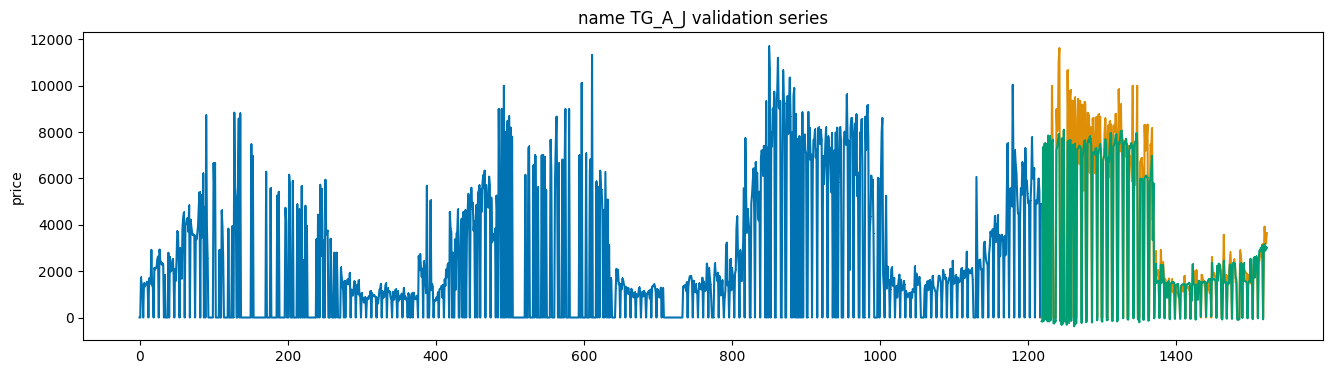

RMSE: 290.3092617069306


  3%|▎         | 1/39 [00:22<14:10, 22.39s/it]

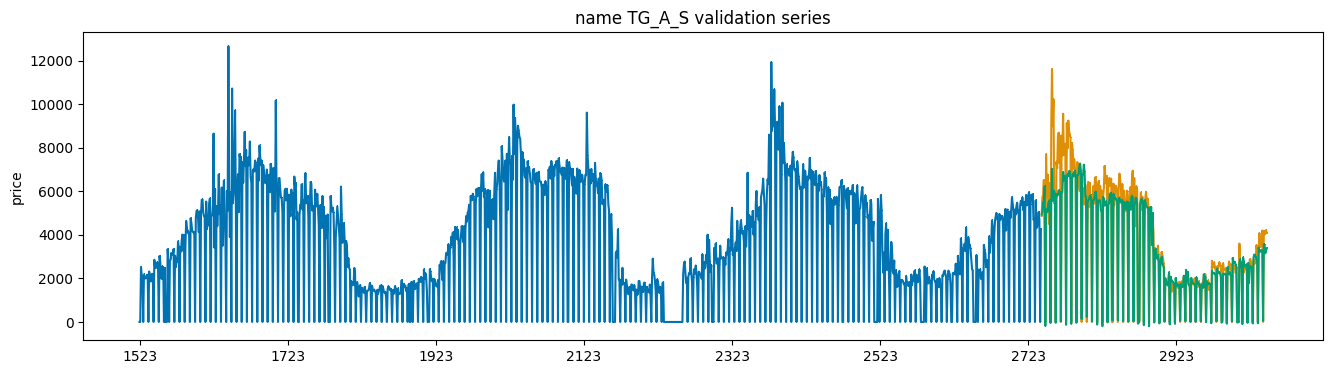

RMSE: 201.04752025841245


  5%|▌         | 2/39 [00:49<15:32, 25.20s/it]

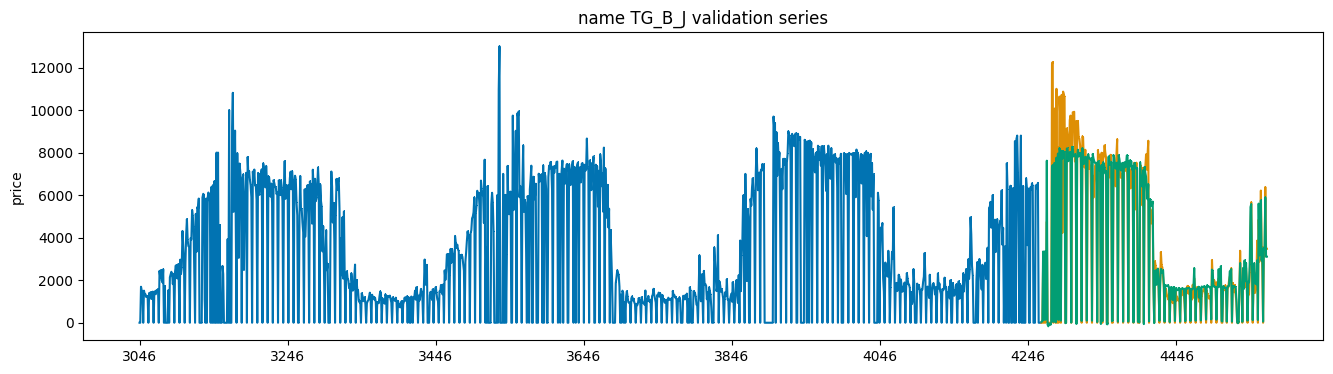

RMSE: 353.85190667426247


  8%|▊         | 3/39 [01:16<15:29, 25.82s/it]

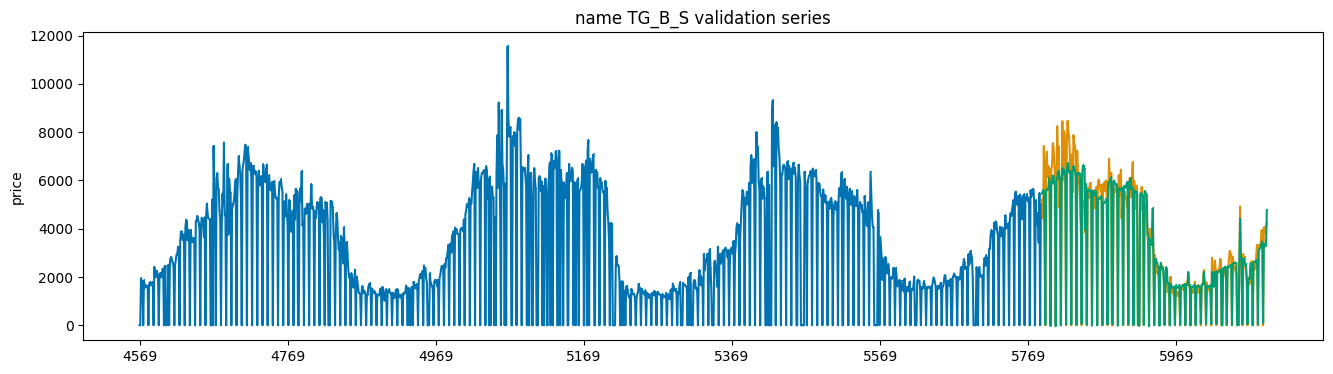

RMSE: 172.39533760948578


 10%|█         | 4/39 [01:43<15:25, 26.46s/it]

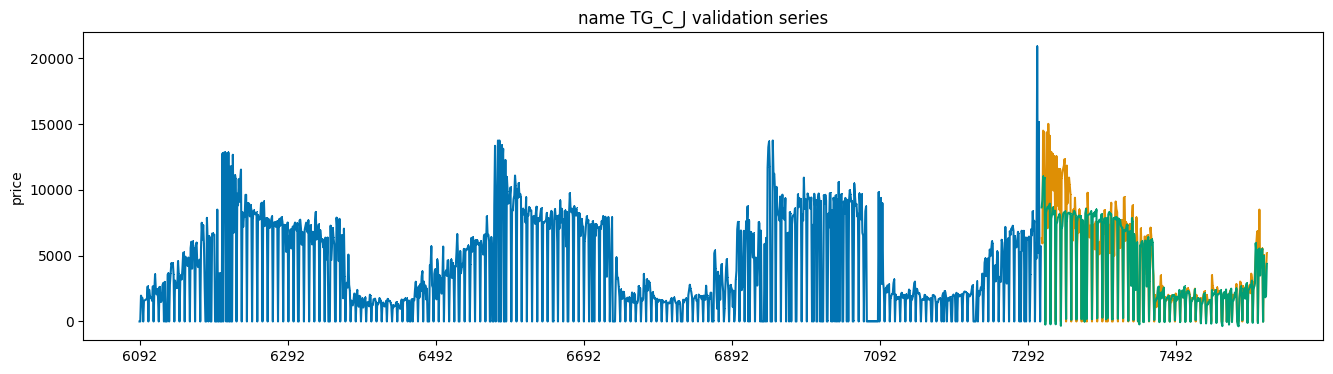

RMSE: 532.263671550355


 13%|█▎        | 5/39 [02:10<15:00, 26.48s/it]

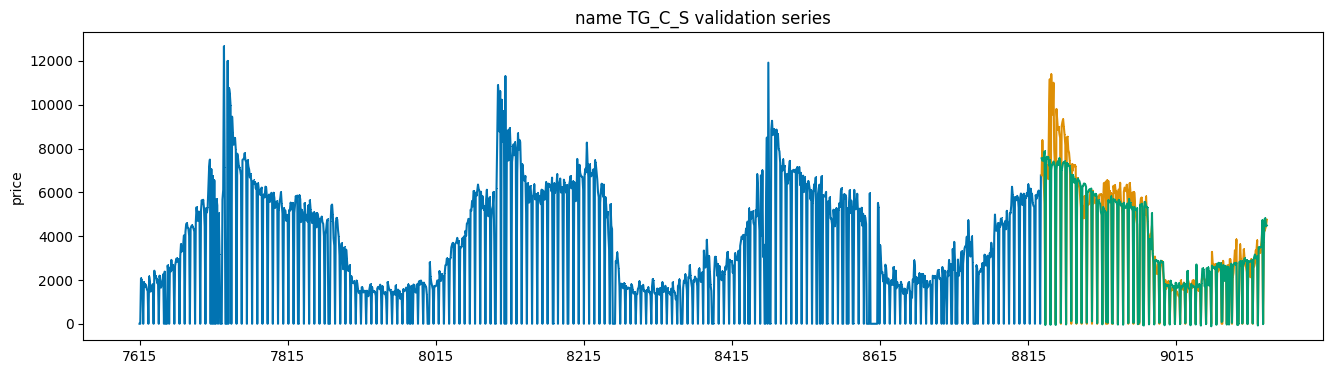

RMSE: 124.17930233932228


 15%|█▌        | 6/39 [02:36<14:32, 26.44s/it]

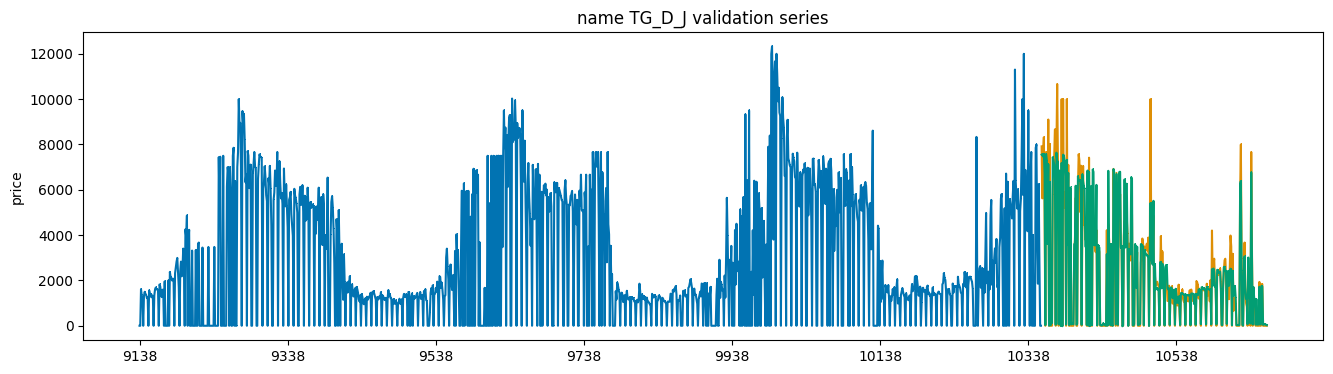

RMSE: 294.107042271783


 18%|█▊        | 7/39 [03:02<14:04, 26.39s/it]

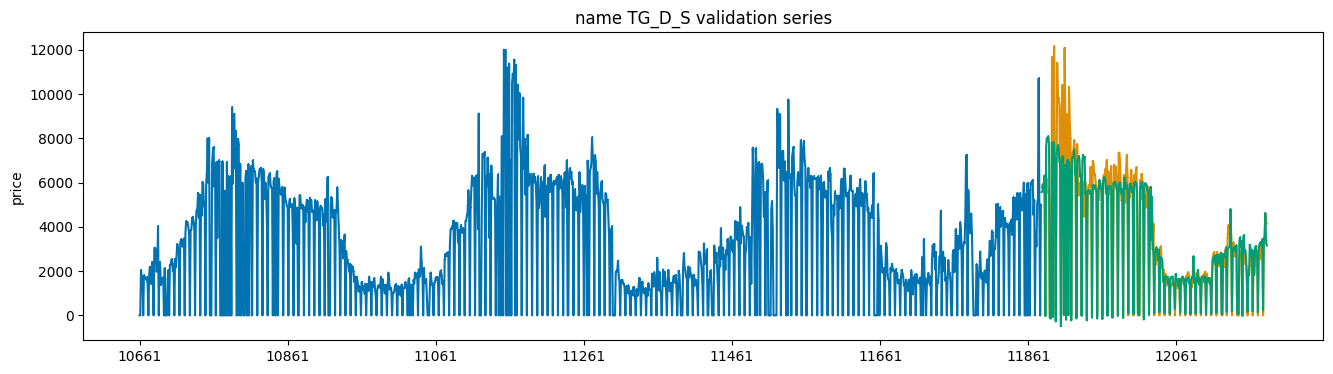

RMSE: 320.3518324041591


 21%|██        | 8/39 [03:30<13:49, 26.76s/it]

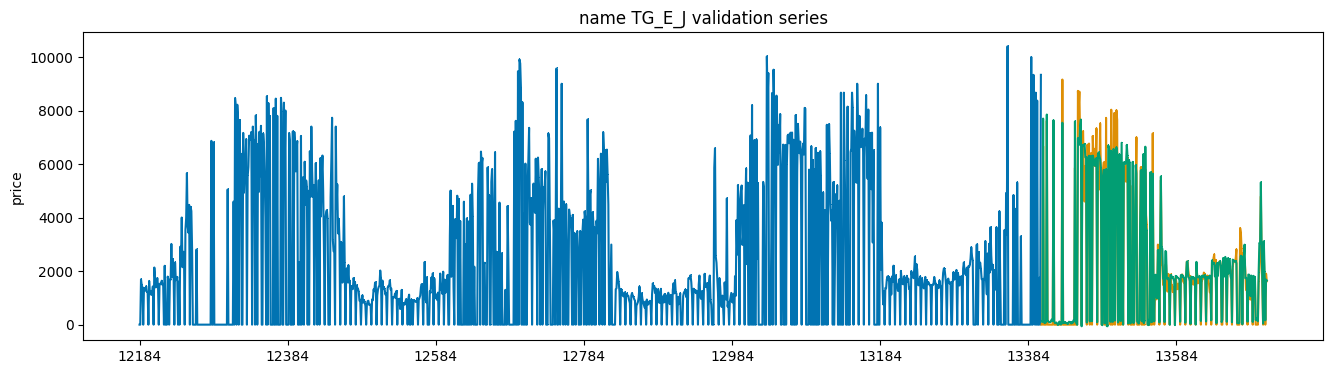

RMSE: 314.8741756361775


 23%|██▎       | 9/39 [03:56<13:15, 26.52s/it]

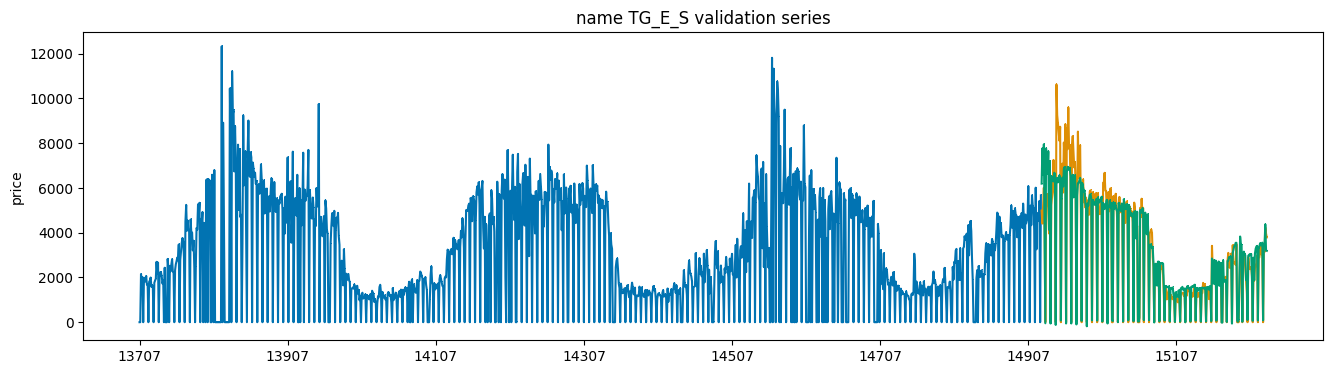

RMSE: 308.2448474456473


 26%|██▌       | 10/39 [04:23<12:54, 26.71s/it]

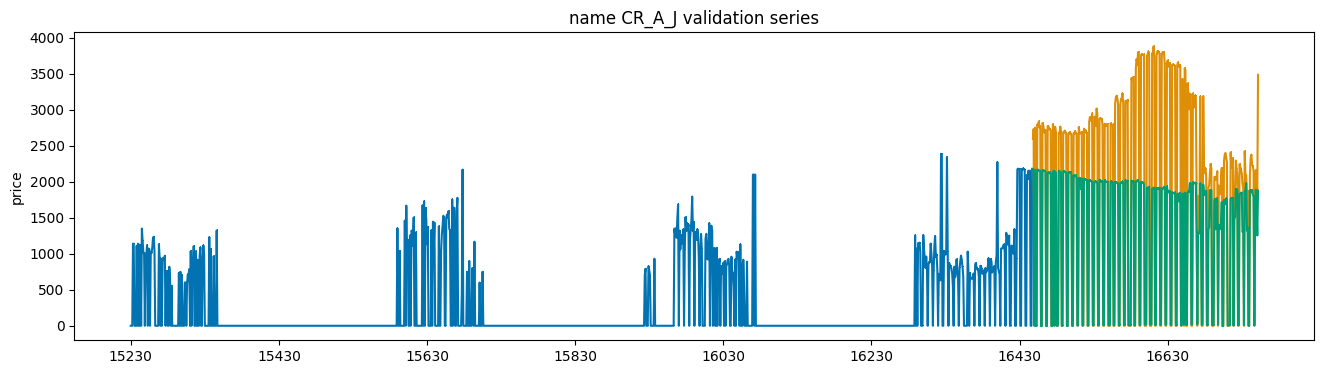

RMSE: 17.05541075733285


 28%|██▊       | 11/39 [04:43<11:35, 24.82s/it]

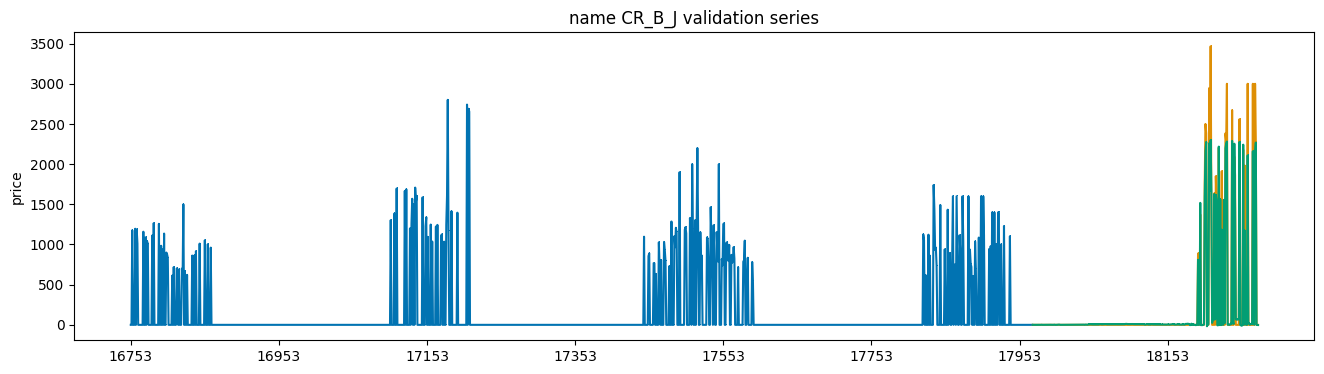

RMSE: 12.657574659123345


 31%|███       | 12/39 [05:03<10:24, 23.12s/it]

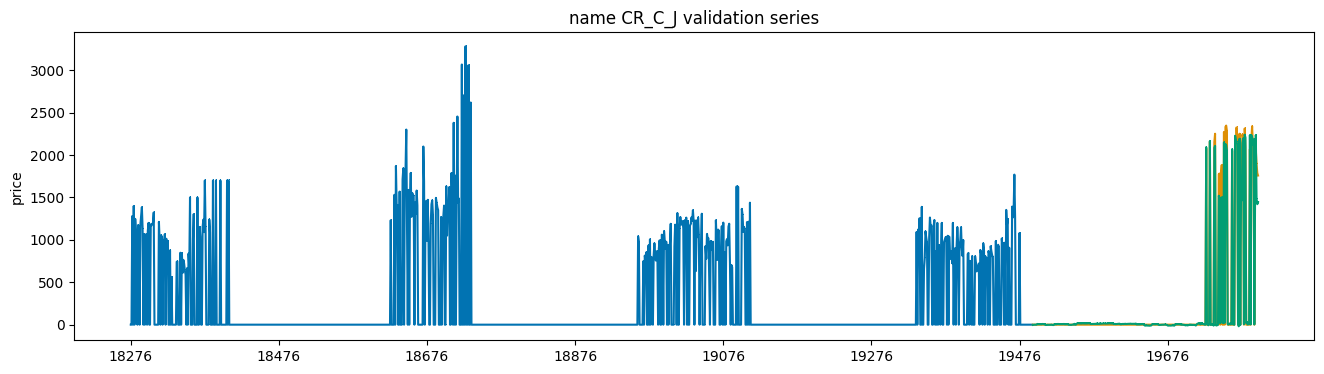

RMSE: 35.7129366841319


 33%|███▎      | 13/39 [05:23<09:36, 22.16s/it]

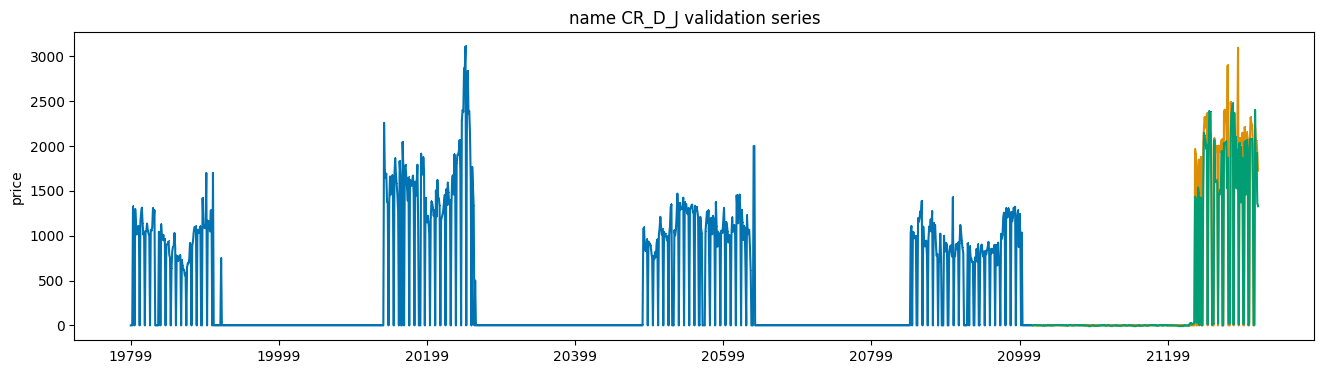

RMSE: 18.52399400349137


 36%|███▌      | 14/39 [05:45<09:14, 22.18s/it]

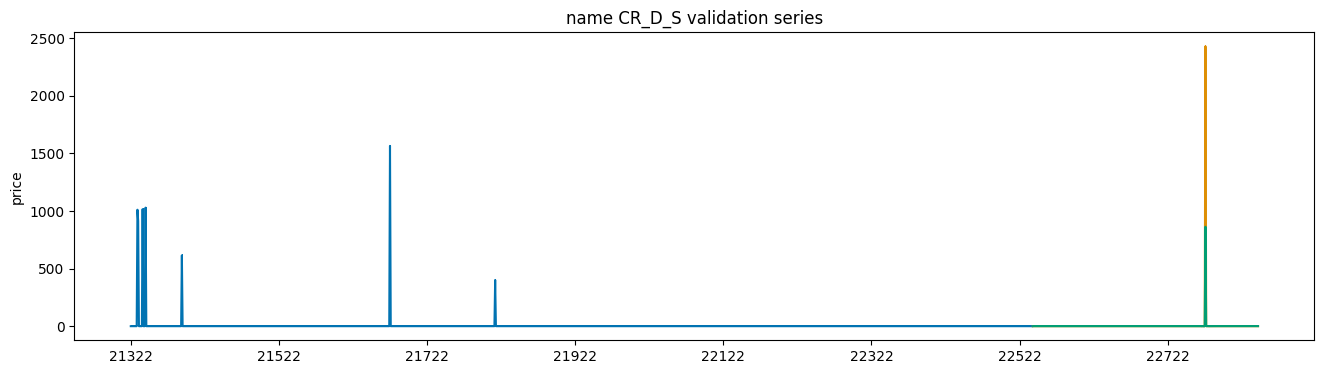

RMSE: 27.01909368826134


 38%|███▊      | 15/39 [06:02<08:12, 20.52s/it]

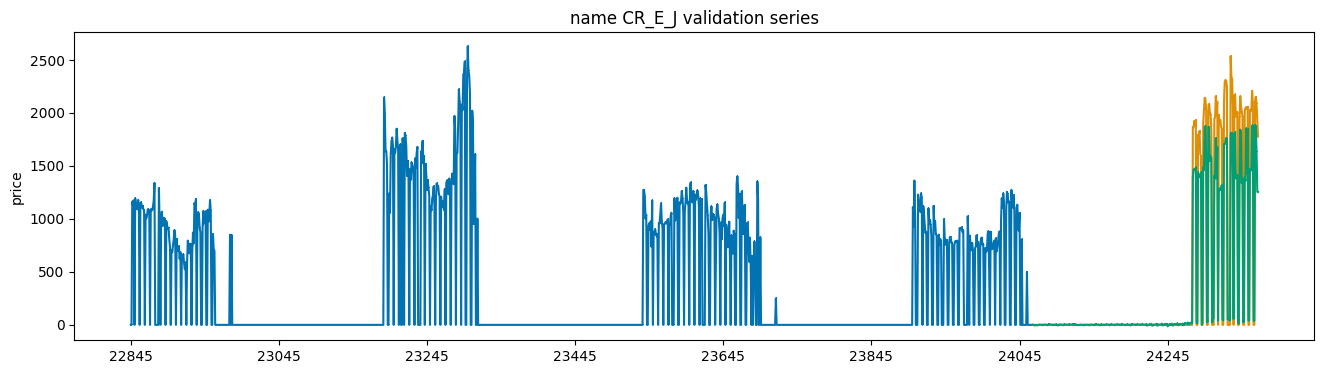

RMSE: 24.049076253656086


 41%|████      | 16/39 [06:22<07:54, 20.63s/it]

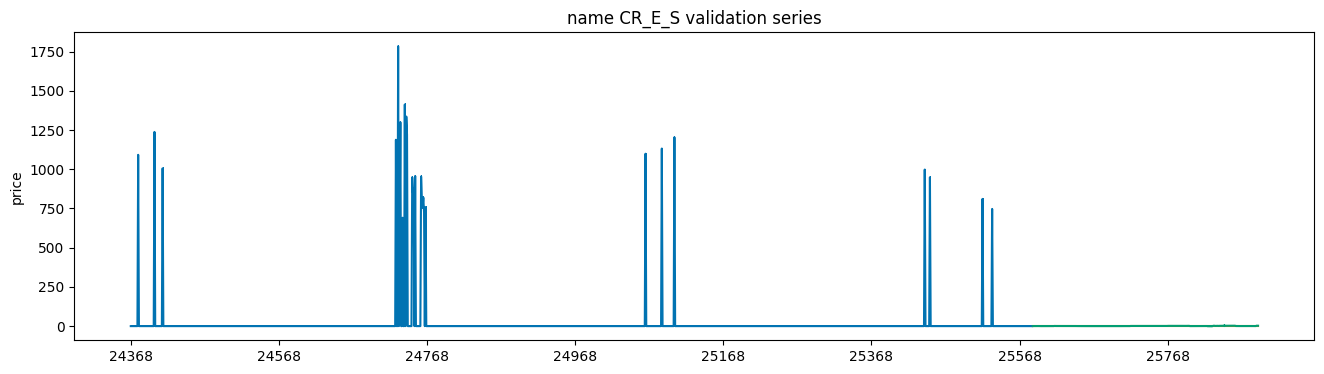

RMSE: 8.312243421911504


 44%|████▎     | 17/39 [06:38<07:01, 19.16s/it]

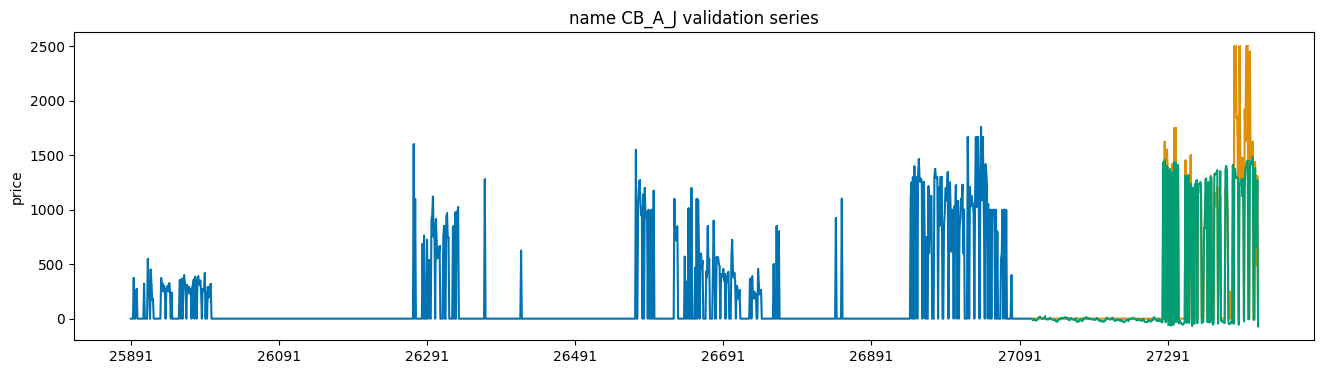

RMSE: 38.192283755848514


 46%|████▌     | 18/39 [06:59<06:50, 19.55s/it]

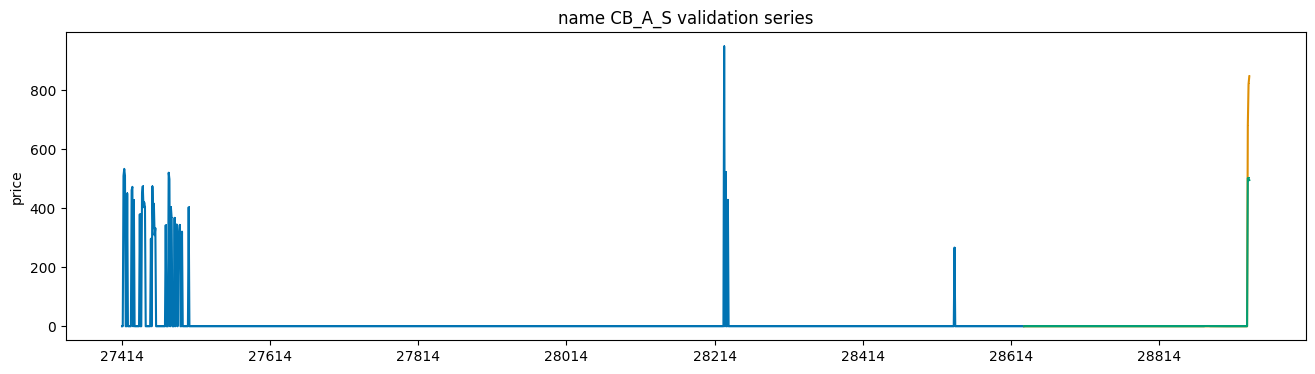

RMSE: 10.899120807811883


 49%|████▊     | 19/39 [07:16<06:16, 18.80s/it]

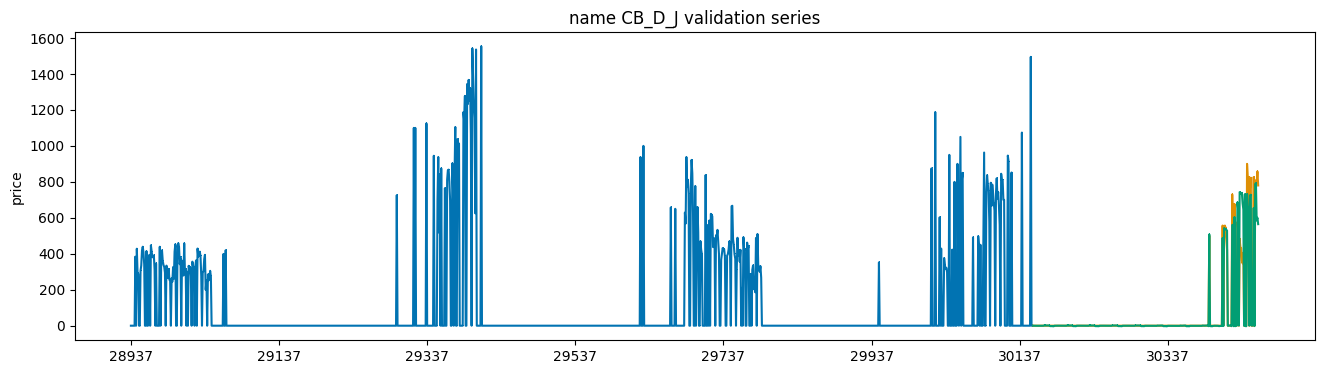

RMSE: 18.133229910126726


 51%|█████▏    | 20/39 [07:37<06:09, 19.47s/it]

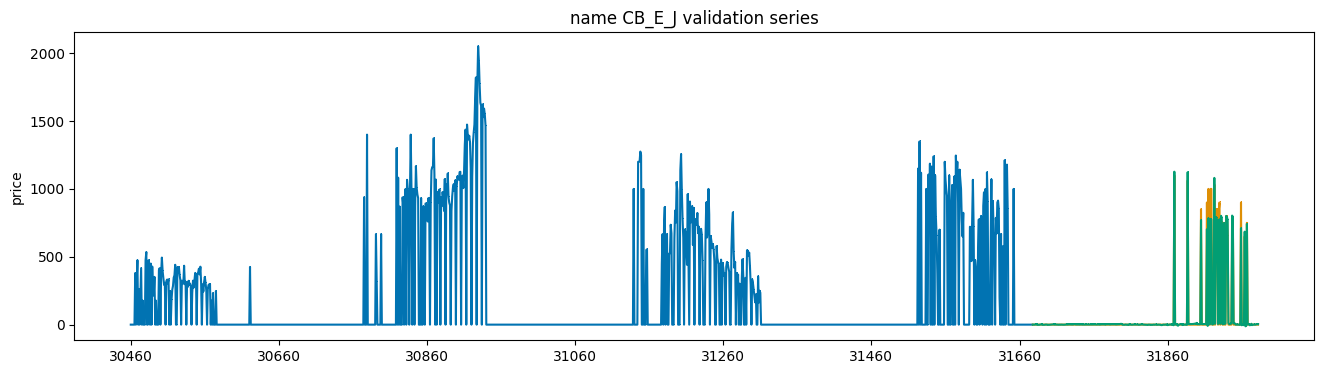

RMSE: 18.346434427448102


 54%|█████▍    | 21/39 [07:58<05:59, 19.95s/it]

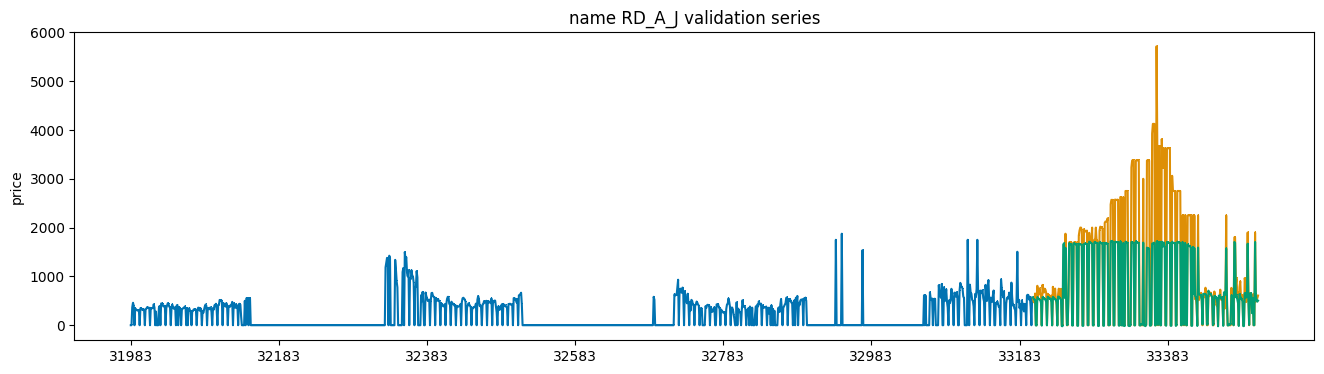

RMSE: 15.078549302973048


 56%|█████▋    | 22/39 [08:20<05:52, 20.72s/it]

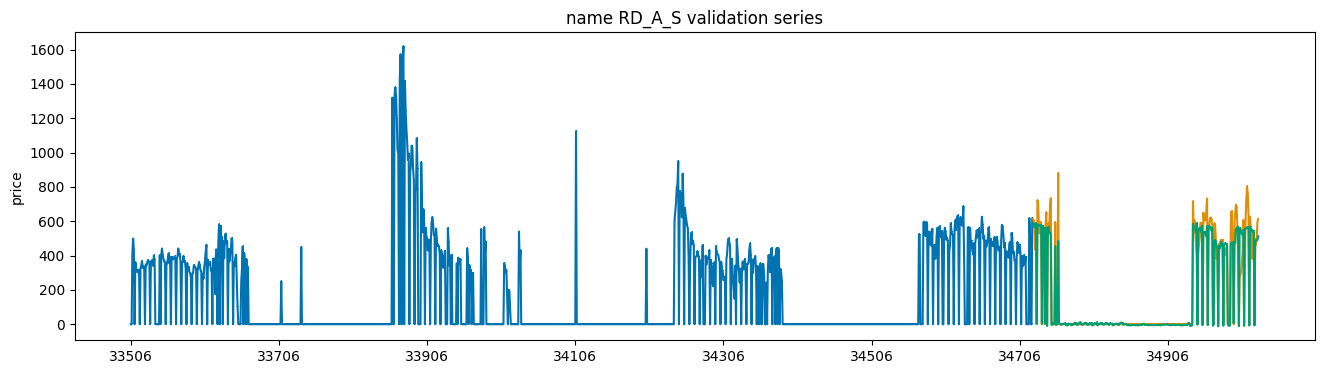

RMSE: 8.565542529009184


 59%|█████▉    | 23/39 [08:42<05:34, 20.92s/it]

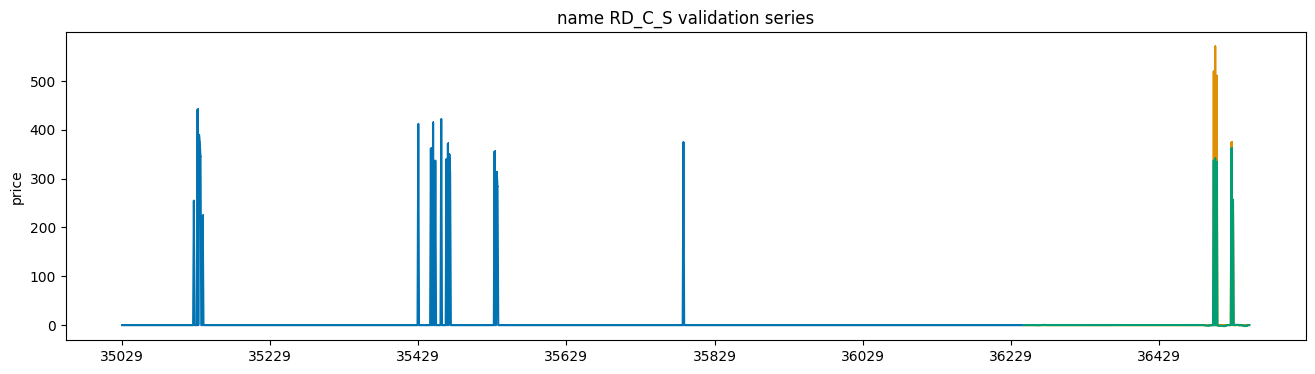

RMSE: 1.7602148707780796


 62%|██████▏   | 24/39 [08:57<04:48, 19.22s/it]

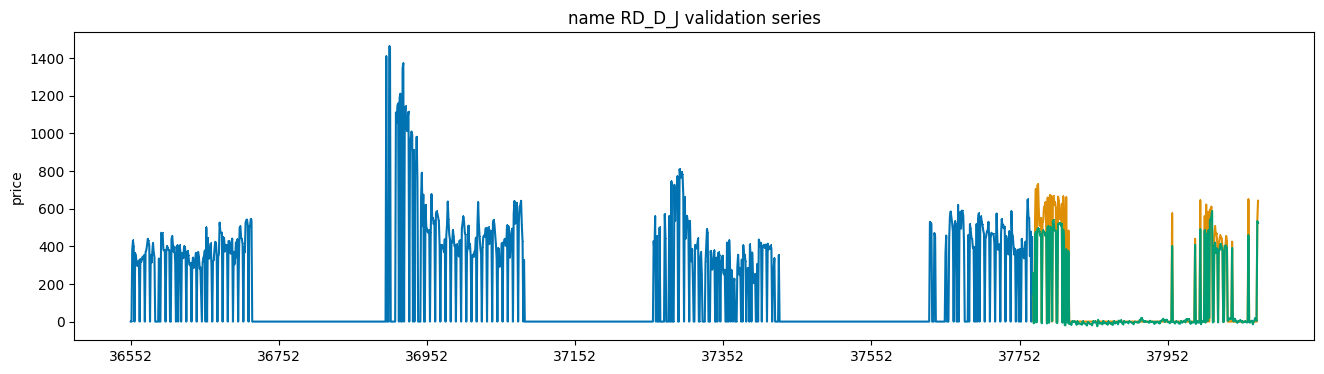

RMSE: 10.470083260182324


 64%|██████▍   | 25/39 [09:18<04:38, 19.91s/it]

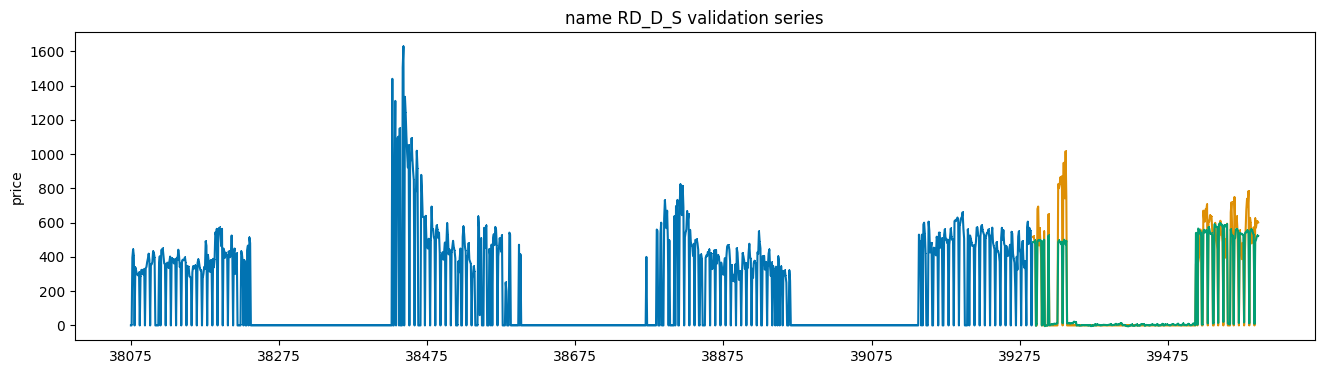

RMSE: 10.689127272912177


 67%|██████▋   | 26/39 [09:40<04:25, 20.46s/it]

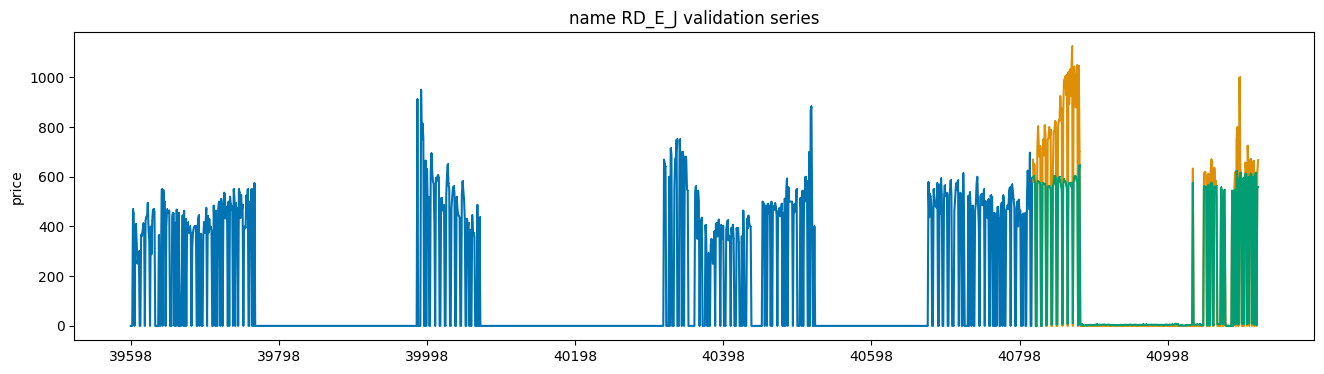

RMSE: 14.225202564102261


 69%|██████▉   | 27/39 [10:01<04:06, 20.58s/it]

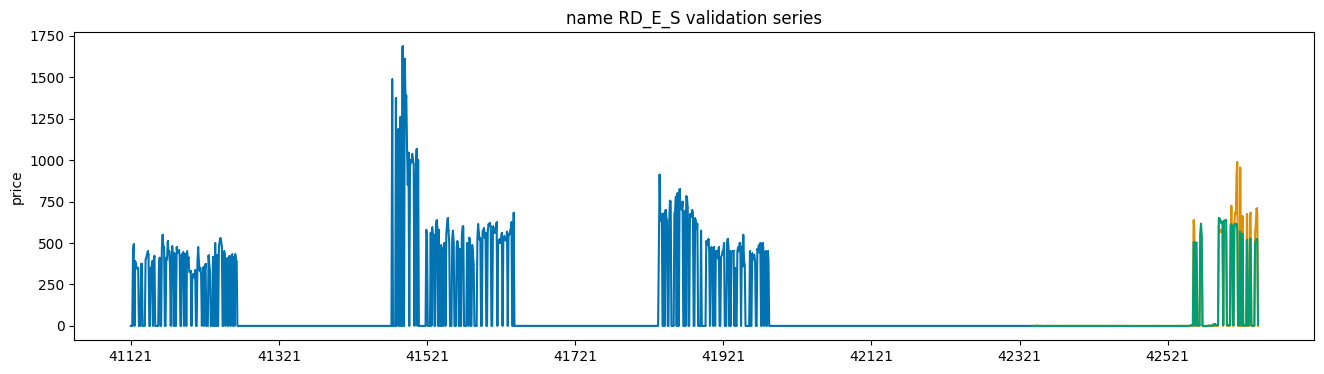

RMSE: 6.837179071230953


 72%|███████▏  | 28/39 [10:19<03:39, 19.93s/it]

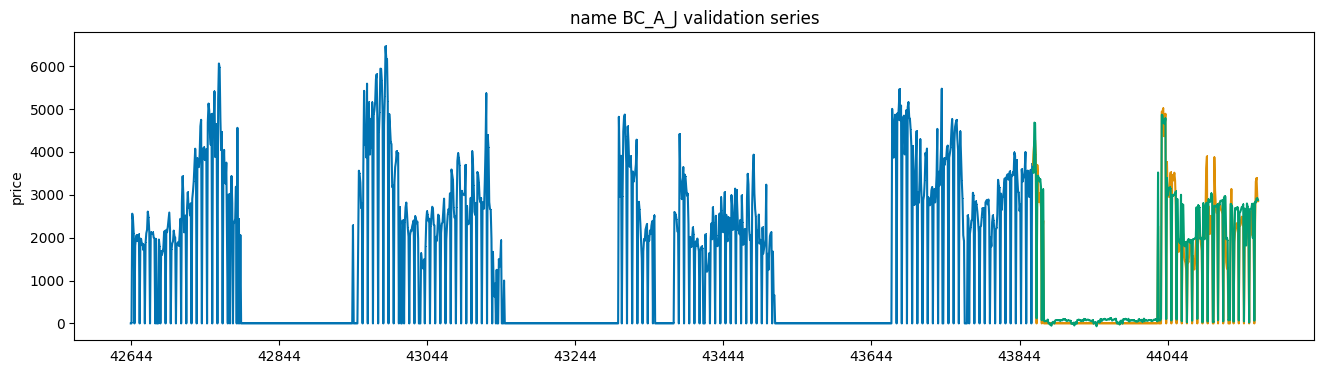

RMSE: 66.39192731631378


 74%|███████▍  | 29/39 [10:43<03:30, 21.00s/it]

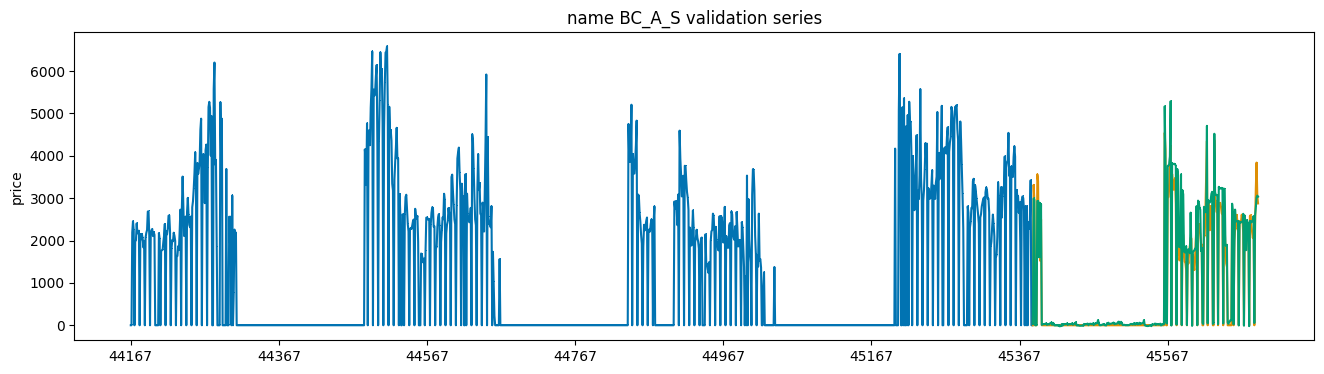

RMSE: 65.63296941624054


 77%|███████▋  | 30/39 [11:06<03:14, 21.63s/it]

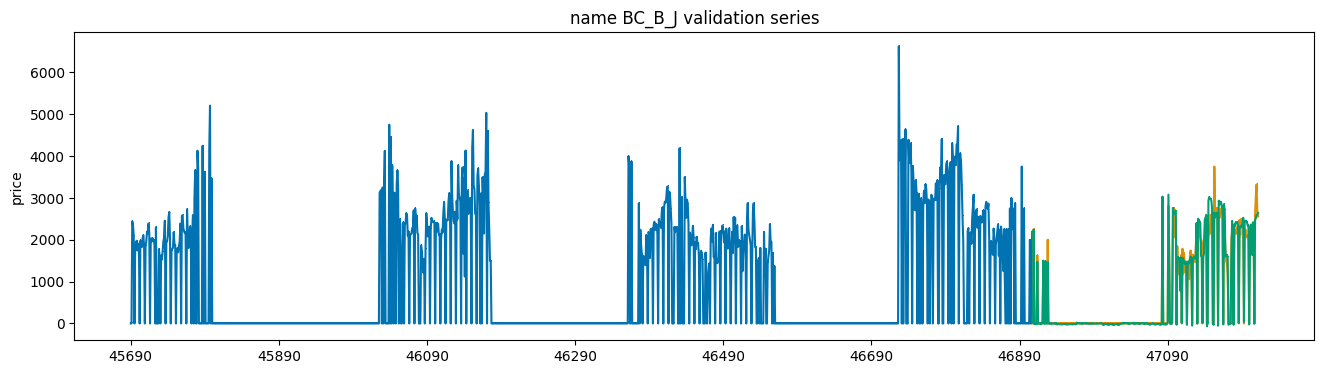

RMSE: 56.569823671957636


 79%|███████▉  | 31/39 [11:28<02:53, 21.64s/it]

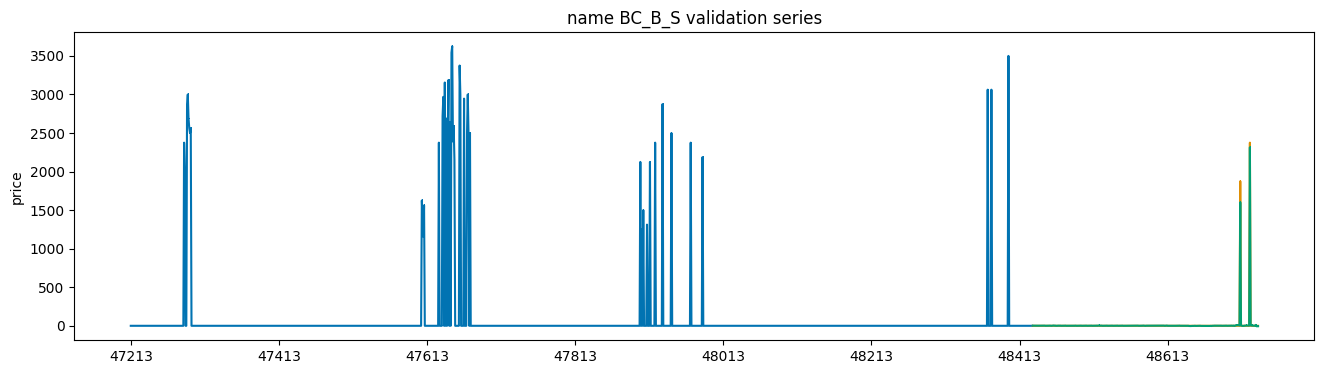

RMSE: 26.487620376806476


 82%|████████▏ | 32/39 [11:45<02:21, 20.22s/it]

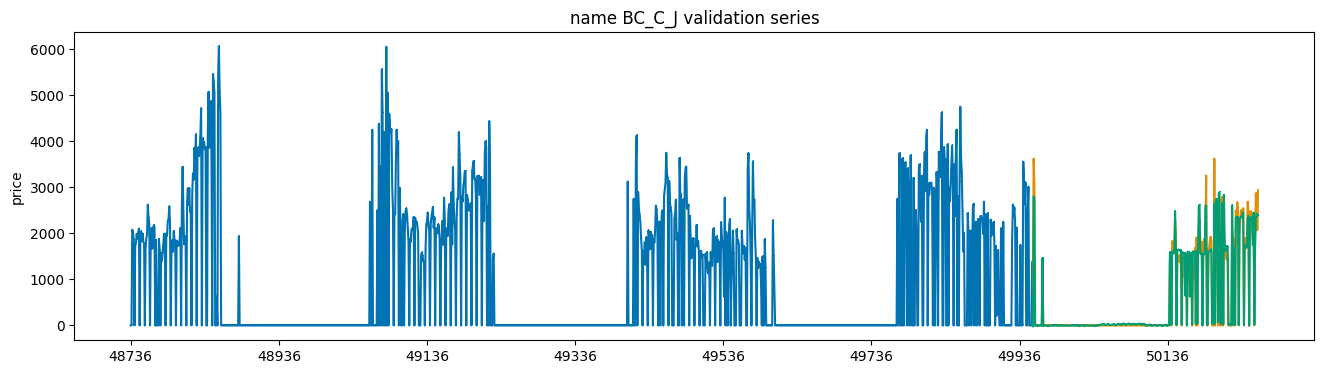

RMSE: 95.71652706952196


 85%|████████▍ | 33/39 [12:08<02:06, 21.15s/it]

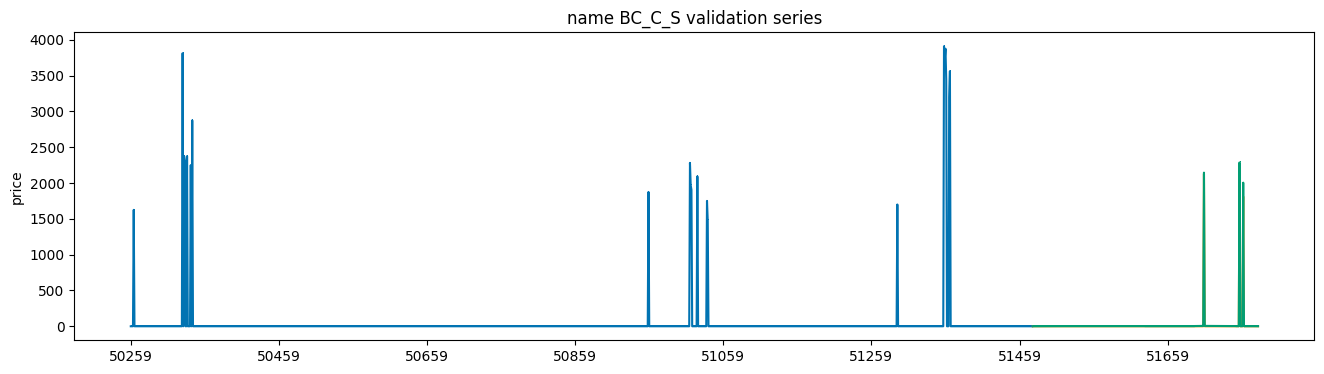

RMSE: 10.123278707100043


 87%|████████▋ | 34/39 [12:25<01:39, 19.82s/it]

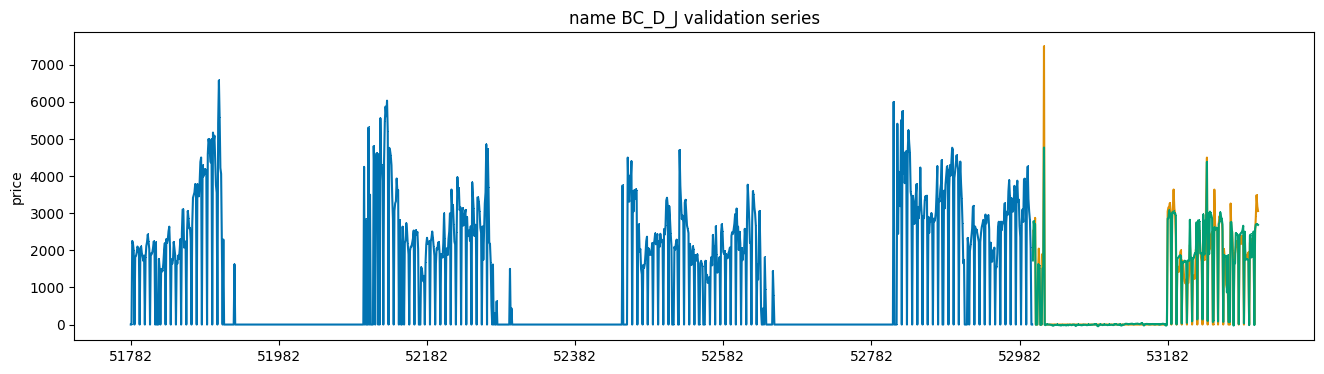

RMSE: 76.18812141157754


 90%|████████▉ | 35/39 [12:48<01:22, 20.73s/it]

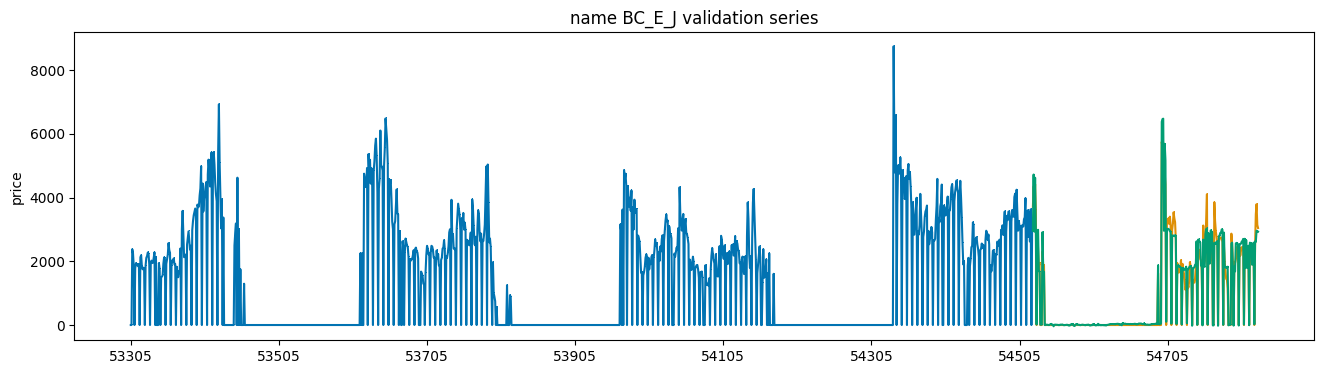

RMSE: 113.06214804704679


 92%|█████████▏| 36/39 [13:11<01:04, 21.53s/it]

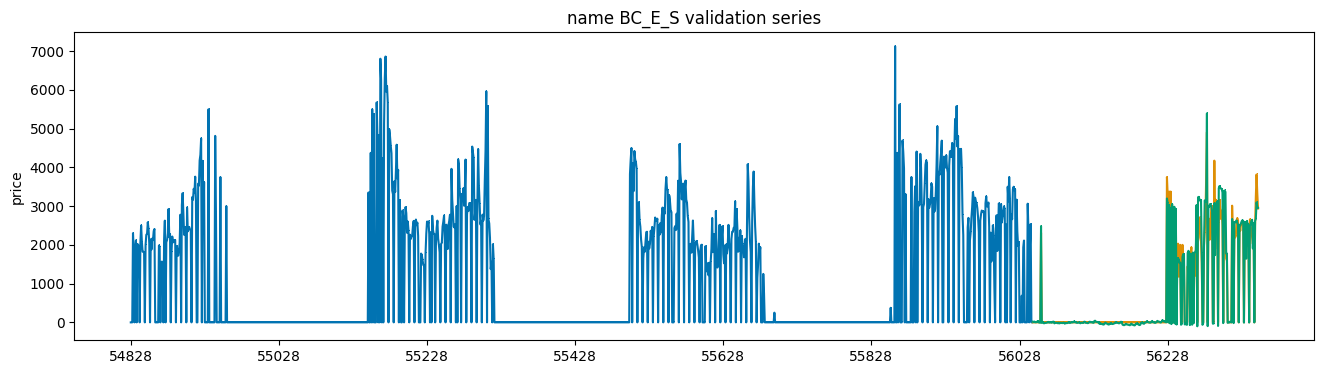

RMSE: 92.54122712467506


 95%|█████████▍| 37/39 [13:35<00:44, 22.17s/it]

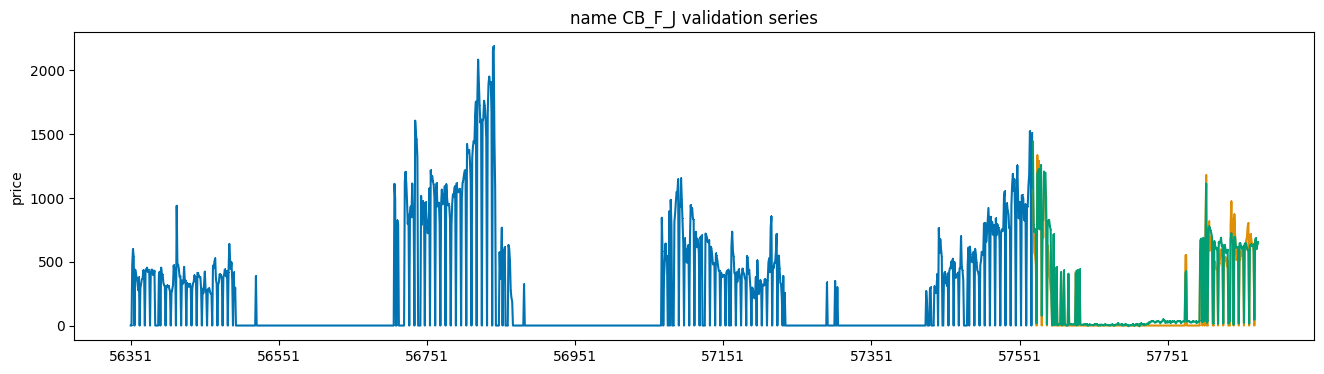

RMSE: 13.839038374588092


 97%|█████████▋| 38/39 [13:58<00:22, 22.66s/it]

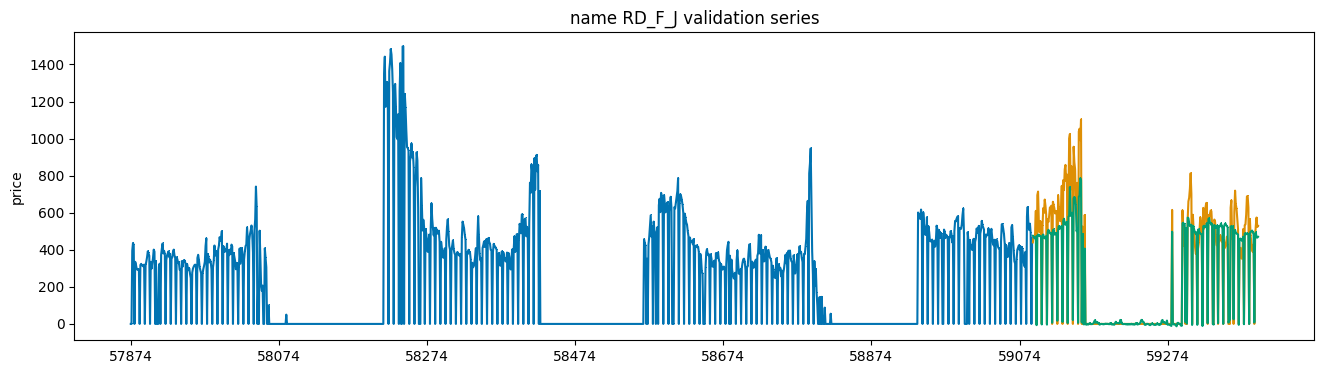

RMSE: 11.626499643993


100%|██████████| 39/39 [14:21<00:00, 22.10s/it]


In [158]:
# import optuna
from sklearn.model_selection import TimeSeriesSplit
from catboost import CatBoostRegressor

# best_params_dict = {}
# predictions_dict = {}
predictions = []
rmse_scores = []

for i in tqdm(train_df.item_id.unique()):
    X = train_df[train_df.item_id == i].drop(columns=['ID', 'price', 'supply', 'item_id','month_of_year'])
    y = train_df[train_df.item_id == i]['price']
    test_X = test_df[test_df.item_id == i].drop(columns=['ID', 'item_id','month_of_year'])


    X_train, X_valid, y_train, y_valid = temporal_train_test_split(X, y, test_size=0.2)

#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=70)  # 적절한 n_trials 값 선택

    # 최적의 하이퍼파라미터 저장
#     best_params_dict[i] = study.best_params

    from sklearn.ensemble import StackingRegressor

    estimators = [
        ("rf", RandomForestRegressor(random_state=SEED)),
        ("lgbm",LGBMRegressor(random_state=SEED)),
        ("xgboost",XGBRegressor(random_state=SEED)),
        ("cat",CatBoostRegressor(random_state=SEED,iterations=200, verbose = 0))
    ]

    params = {
        "estimators" : estimators,
    #     "final_estimator" : LinearRegression(**best_params),
        "final_estimator" : LinearRegression(),
        "cv" : cv,
        "n_jobs":-1
    }

    model_ensemble= StackingRegressor(**params)

    model_ensemble.fit(X_train, y_train)
    X_pred = model_ensemble.predict(X_train)
    X_rmse = np.sqrt(mean_squared_error(y_train, X_pred))
    rmse_scores.append(X_rmse)

    pred = model_ensemble.predict(X_valid)
    pred = pd.Series(pred)
    pred.index = np.arange(y_valid.index[0], y_valid.index[-1]+1)
    plot_series(y_train, y_valid, pd.Series(pred), markers=[',' , ',', ','])
    plt.title(f'name {i} validation series')
    plt.show()
    print(f'RMSE: {X_rmse}')

    model_ensemble.fit(X,y)
    pred_target = model_ensemble.predict(test_X)
    predictions.append(pred_target)

    # predictions_dict[i] = pd.Series(pred)





In [159]:
sum(rmse_scores)/ len(rmse_scores)

98.36747118709455

In [169]:
predictions

[array([3401.48243995,   41.99831113, 4930.36691325, 4748.35018996,
        4823.84014989, 3282.47625335, 3274.06690329, 3175.65262583,
          -8.49817018, 5123.23570484, 4923.76831855, 5033.4999163 ,
        3184.91592674, 3121.09696183, 3095.10285276,  -66.03926683,
        5201.75226885, 5079.9923957 , 5110.77056765, 3167.58852978,
        3057.98748107, 3320.74346437,   63.66736576, 5875.86369952,
        5746.32136166, 5723.96769406, 3204.88615767, 3183.2628877 ]),
 array([3677.13319622,  154.629121  , 4926.7870501 , 4898.17669   ,
        4968.80141708, 3918.19793598, 3829.54160624, 3645.35175993,
         143.14099906, 4966.40054294, 4903.10295709, 5005.27329248,
        3951.38223573, 3955.66055259, 3766.0387237 ,  139.06387389,
        5019.45953287, 5054.59539421, 4980.38903126, 3999.33866375,
        3920.81905045, 3747.25618801,   90.34101664, 5039.21355041,
        5021.09268016, 4995.31508374, 3911.06775712, 3857.10313263]),
 array([3420.88269827,  139.03981975, 5808.0

In [170]:
total_prediction = []

for i in predictions:
    for j in i :
        total_prediction.append(j)


In [171]:
for i in total_prediction :
    print(i)

3401.4824399477416
41.99831113026241
4930.366913247444
4748.350189955321
4823.840149885207
3282.4762533471094
3274.0669032938385
3175.6526258307167
-8.4981701804017
5123.235704837531
4923.768318546947
5033.49991630015
3184.9159267379014
3121.096961826158
3095.102852757967
-66.03926682657074
5201.75226885283
5079.992395696299
5110.770567650119
3167.5885297753525
3057.9874810715964
3320.743464374056
63.6673657567481
5875.863699516978
5746.321361661885
5723.967694061448
3204.8861576745508
3183.262887701846
3677.1331962155496
154.62912099841915
4926.78705009821
4898.17669000436
4968.801417079099
3918.1979359834336
3829.5416062370055
3645.3517599305537
143.1409990610003
4966.400542941621
4903.1029570885985
5005.273292481057
3951.3822357343684
3955.6605525880714
3766.038723702101
139.0638738902204
5019.459532867613
5054.595394207603
4980.3890312618805
3999.338663754055
3920.8190504500812
3747.256188006311
90.34101664095158
5039.213550411136
5021.092680157182
4995.3150837439025
3911.067757119

In [172]:
len(total_prediction)

1092

In [173]:
total_prediction = np.array(total_prediction)

In [174]:
total_prediction[total_prediction < 0] = 0

In [175]:
total_prediction

array([3401.48243995,   41.99831113, 4930.36691325, ...,  471.12900471,
        440.90582911,  437.17005574])

In [176]:
submission['answer'] = total_prediction
submission

,ID,answer
0,TG_A_J_20230304,3401.482440
1,TG_A_J_20230305,41.998311
2,TG_A_J_20230306,4930.366913
3,TG_A_J_20230307,4748.350190
4,TG_A_J_20230308,4823.840150
...,...,...
1087,RD_F_J_20230327,478.954668
1088,RD_F_J_20230328,501.694033
1089,RD_F_J_20230329,471.129005
1090,RD_F_J_20230330,440.905829


In [177]:
submission.to_csv('itemid_modeling_v10_1114.csv', index=False)

# AutoGluon

In [ ]:
# mask = train_df['ID'].str.startswith('TG')
# train_df_tg = train_df[mask]
# mask = test_df['ID'].str.startswith('TG')
# test_df_tg = test_df[mask]

# mask = train_df['ID'].str.startswith('BC')
# train_df_bc = train_df[mask]
# mask = test_df['ID'].str.startswith('BC')
# test_df_bc = test_df[mask]

# mask = train_df['ID'].str.startswith('RD')
# train_df_rd = train_df[mask]
# mask = test_df['ID'].str.startswith('RD')
# test_df_rd = test_df[mask]

# mask = train_df['ID'].str.startswith('CB')
# train_df_cb = train_df[mask]
# mask = test_df['ID'].str.startswith('CB')
# test_df_cb = test_df[mask]

# mask = train_df['ID'].str.startswith('CR')
# train_df_cr = train_df[mask]
# mask = test_df['ID'].str.startswith('CR')
# test_df_cr = test_df[mask]


In [ ]:
# pattern = '자두|수박|사과|복숭아|배|감귤'
# mask = trade_df['item'].astype(str).str.contains(pattern, regex=True)
# exp_fruit = trade_df[mask]


# pattern = '그레이프|망고스틴|오렌지|파인애플'
# mask = trade_df['item'].astype(str).str.contains(pattern, regex=True)
# imp_fruit = trade_df[mask]

In [ ]:
# exp_fruit_df = exp_fruit.groupby()

In [ ]:
train_df

In [ ]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [ ]:
train_dropcols = ['ID', 'supply', 'month_of_year']
test_dropcols = ['ID', 'month_of_year']

In [ ]:
train_ft = train_df.drop(columns = train_dropcols)
test_ft = test_df.drop(columns = test_dropcols)

In [ ]:
train_ft.columns

In [ ]:
# from autogluon.tabular import TabularPredictor
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
data = TimeSeriesDataFrame(train_ft)

In [ ]:
data.static_features

In [ ]:
predictor = TimeSeriesPredictor(
    prediction_length=28,
    target="price",
    eval_metric="RMSE",

    # quantile_levels=[0.05, 0.5, 0.95],
    # known_covariates_names=["holiday"]

)
# seed 고정
# predictor.fit(data,presets="best_quality",random_seed=SEED)
predictor.fit(data,random_seed=SEED, presets = 'best_quality',time_limit=3600)

In [ ]:
train_ft.info()

# 예측

In [ ]:
# 모델 재학습
predictor.refit_full()

In [ ]:
pred = predictor.predict(data, random_seed=SEED)
pred

In [ ]:
predictor.leaderboard(data, silent=True)


In [ ]:
predictor.get_model_best()

In [ ]:
pred = pred.reset_index()['mean']
pred

In [ ]:

# 마이너스 값 0으로 치환
pred[pred < 0] = 0

# 제출

In [ ]:
submission

In [ ]:
submission['answer'] = pred
submission

In [ ]:
submission.to_csv(f"{DATA_PATH}submission_v10_1114.csv", index=False)
submission.to_csv("submission_v10_1114.csv", index=False)